## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [1]:
# Questions to answer
# 1. What does the current KC housing market look like? What do the majority of houses have in common? Any major
# - - outliers?
#
# 2. [Multicollinearity - - if only certain pieces of data are available in the future on houses]
# 3. [...]

In [2]:
# Your code here - remember to use markdown cells for comments as well!
# Predict housing prices to be used by PE shop looking for valuation help.

In [4]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

In [5]:
# function to perform stepwsise selection
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [6]:
"""
Function to plot y vs. a chosen set of x variables: includes regression line
"""

def plot_relationship(data, y_vars, x_vars, height=4.5):
    grid = sns.PairGrid(data=data, y_vars=y_vars, x_vars=x_vars, height=height)
    grid.map(sns.regplot)

In [7]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [8]:
# import the dataset
raw_data = pd.read_csv('kc_house_data.csv')

In [9]:
# examine the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [10]:
# drop the id column as that won't be relevant
clean_data = raw_data.drop('id', axis=1)

In [11]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [12]:
# Handle Missing Values
# waterfront, yr_renovated, view

# evaluate waterfront
clean_data['waterfront'].nunique()

2

In [13]:
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [14]:
# how many nans are there
clean_data['waterfront'].isna().sum()

2376

In [15]:
# given how many values this is, going to keep data in for now
# set all nans to 0 as houses missing waterfront info likely are not 
# waterfront
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [16]:
# Handle yr_renovated missing values
clean_data['yr_renovated'].nunique()

70

In [17]:
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [18]:
# how many are missing
clean_data['yr_renovated'].isna().sum()

3842

In [19]:
# similar to waterfront, assume missing data are 0's are non-renos
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [20]:
# Handle view missing values
clean_data['view'].isna().sum()

63

In [21]:
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [22]:
# view is the number of times a house has been viewed
# set missing values to 0 with the assumption that missing values have
# no views
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [23]:
# check for remaining missing values
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [24]:
# no more missing values
# check for duplicates
clean_data.duplicated().sum()

0

In [25]:
# There are no duplicates -- handle strings and convert all columns
# to appropriate d type for regression
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [26]:
# only string columns are the date and sqft_basement
# evaluate sqft_basement
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [27]:
# replace '?' with zero with assumption that these do not have basements
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace='?',
                                                                      value='0.0')

In [28]:
# convert to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [29]:
# handle date column - convert to a datetime type and then split year, month, day
clean_data['date'] = pd.to_datetime(clean_data['date'], infer_datetime_format=True)

In [30]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  float64       
 8   view           21597 non-null  float64       
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  float64       
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  float64       
 15  zipcode        2159

In [31]:
# create individual columns for year, month, and day
clean_data['year_sold'] = clean_data['date'].map(lambda x: x.year)
clean_data['month_sold'] = clean_data['date'].map(lambda x: x.month)
clean_data['day_sold'] = clean_data['date'].map(lambda x: x.day)

In [32]:
# drop date column
clean_data = clean_data.drop('date', axis=1)

In [33]:
# now we have handled missing values, duplicates, obvious weird values,
# and changed the types of columns appropriately
# check that columns are looking ok
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

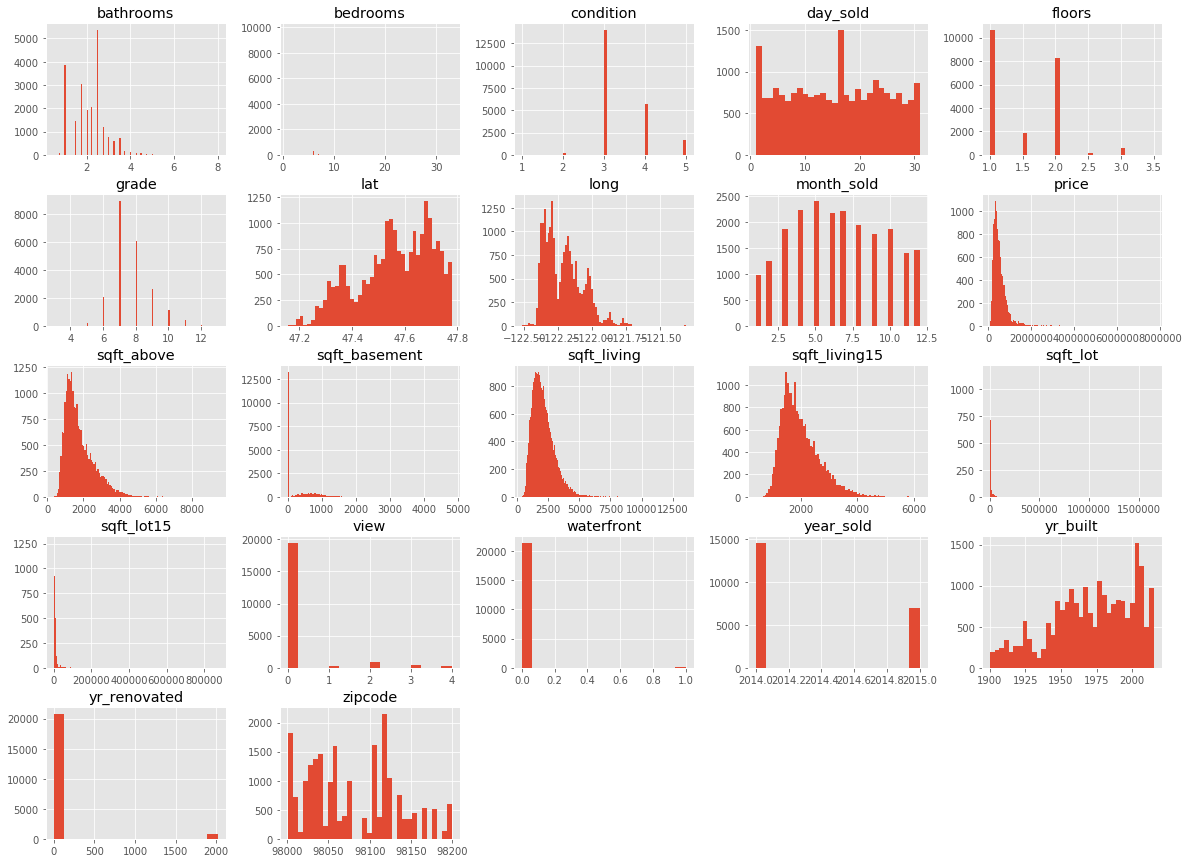

In [34]:
# histograms for all variables
clean_data.hist(figsize=(20,15), bins='auto');

In [32]:
# price, sqft_above, sqft_living, sqft_living15 all appear continuous and log normally distributed
# the majority of houses seem to have less than 4 bathrooms
# most houses have a condition of 3 or higher
# the majority of houses have 2 floors or less
# there are a large number of houses with 0 sqft_basement, likely a result of not having a basement

In [33]:
# evaluate distributions / relationships, etc.
# separate continious and cat variables; remove cont variables that do not meet linearity req
# run a baseline model, evaluate residuals for assumption requirements
# cross fold validation

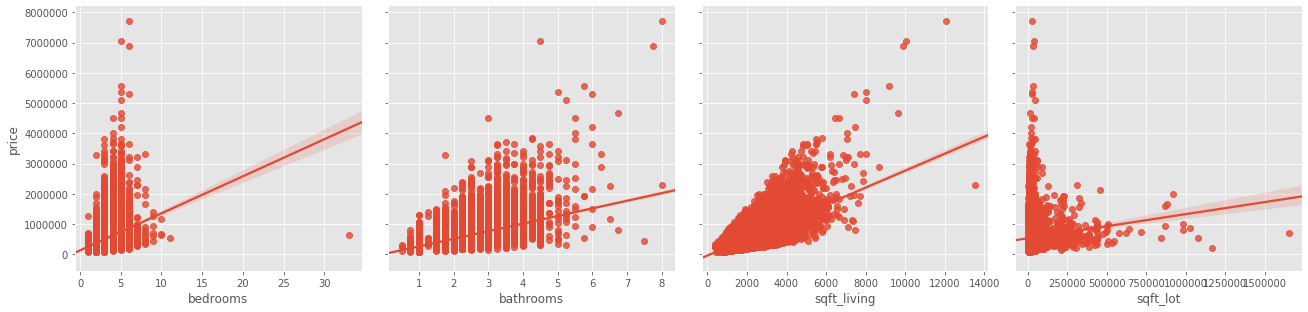

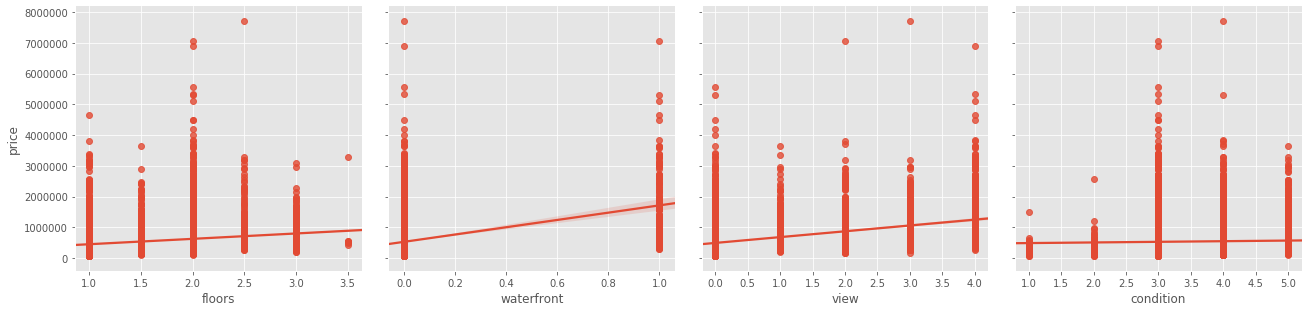

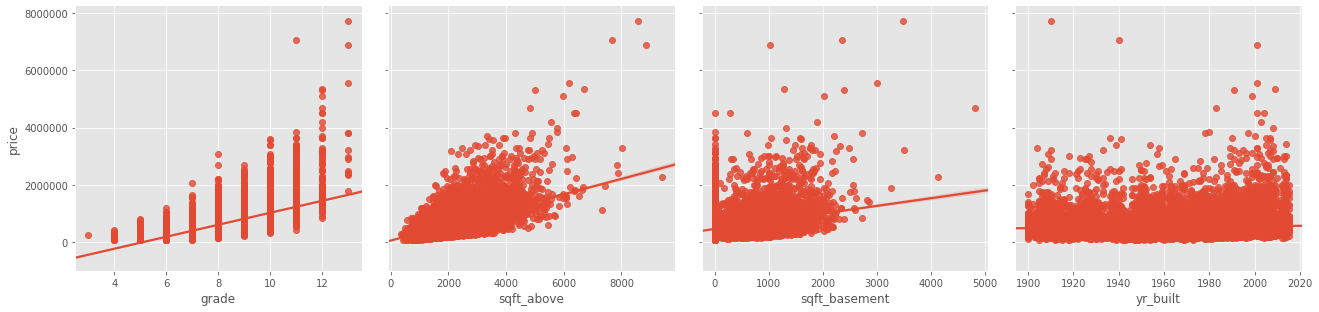

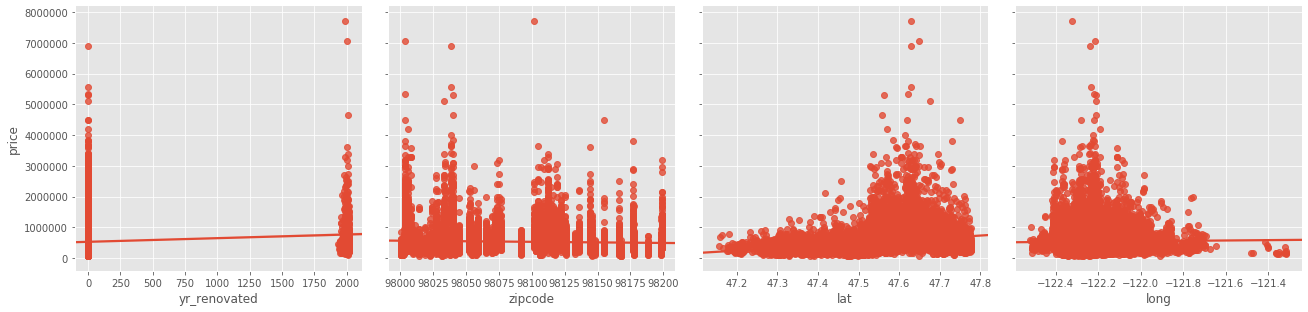

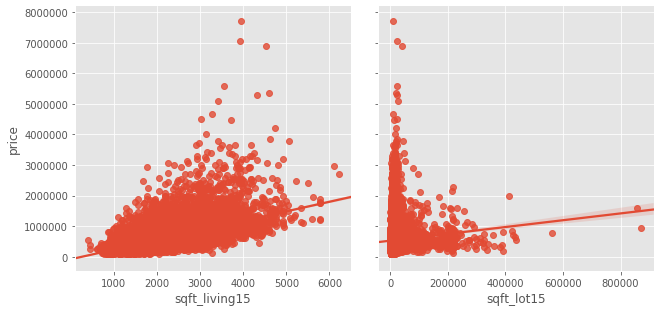

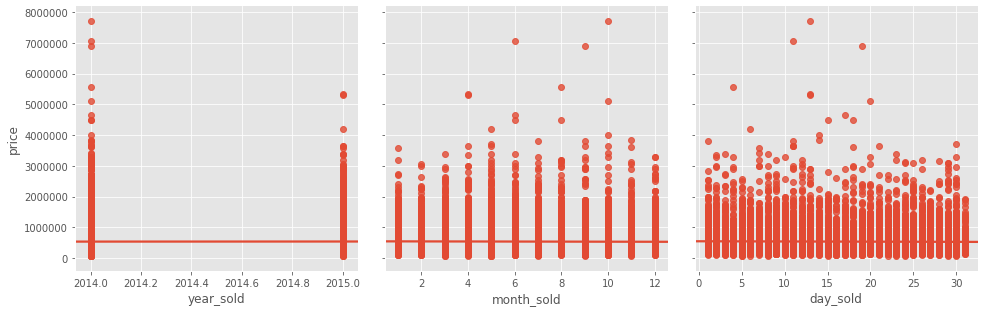

In [35]:
# plot all against price to check linearity assumptions
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living15', 'sqft_lot15'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

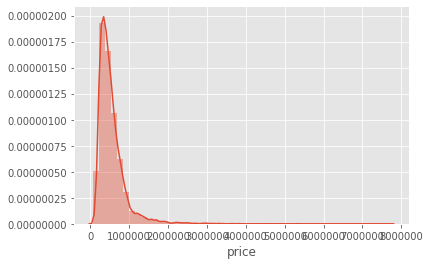

In [36]:
# there are a number of outliers - - it seems many of these are related to abnormally high prices
# look at the distribution of price again
sns.distplot(clean_data['price'])

In [37]:
# looks log normally distributed - - log transform
clean_data['price'] = np.log(clean_data['price'])

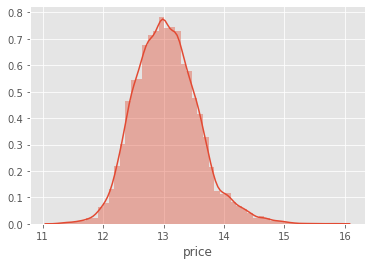

In [39]:
# replot
sns.distplot(clean_data['price'])

In [42]:
# looking more normal

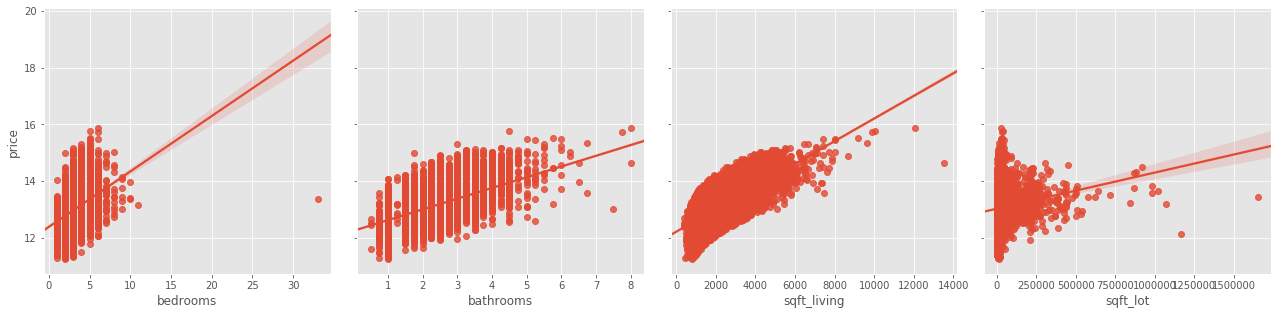

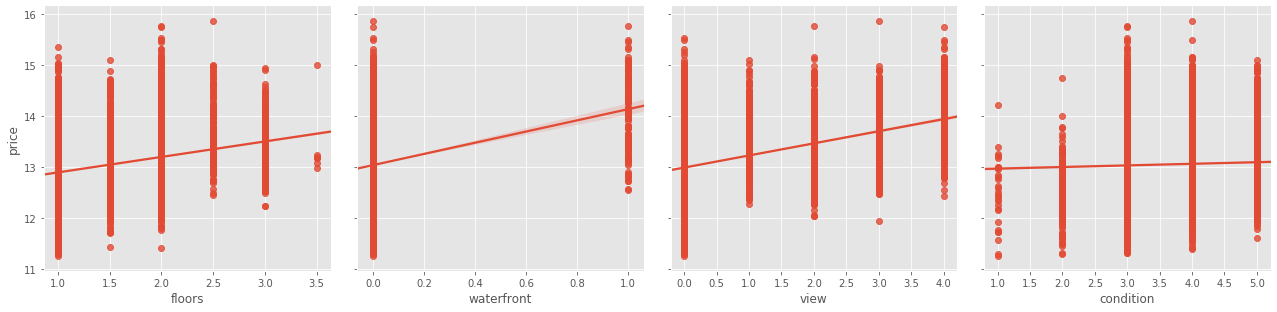

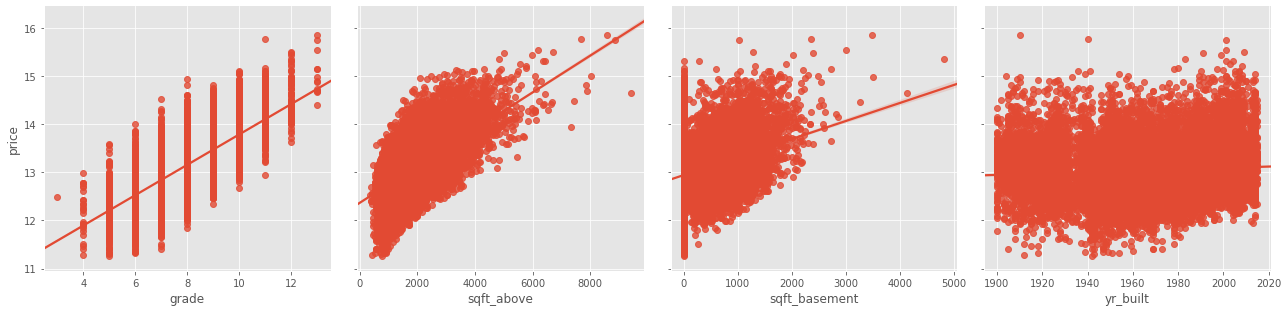

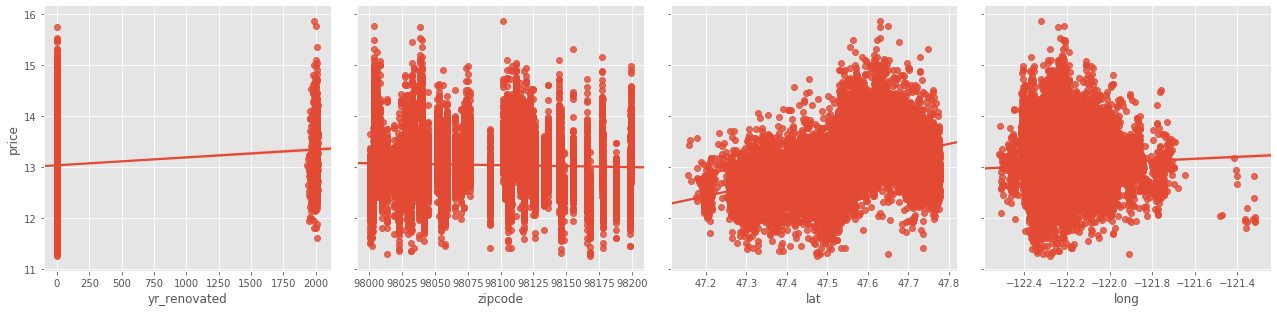

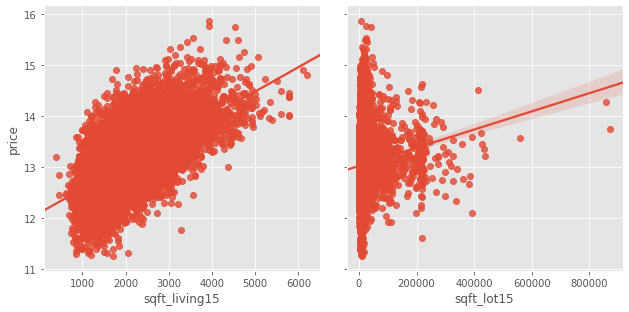

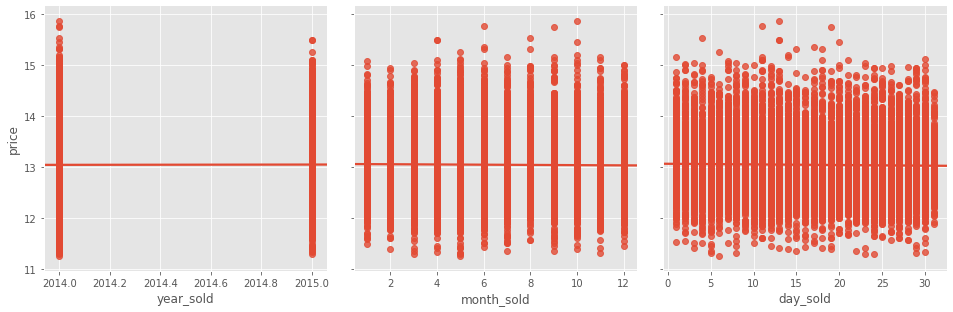

In [41]:
# plot all against price to check linearity assumptions
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living15', 'sqft_lot15'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

In [43]:
# identify categorical and non-cat columns
cat_columns = ['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'year_sold', 
               'month_sold', 'day_sold']

In [44]:
cont_columns = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15']
cont_vars = clean_data[cont_columns]

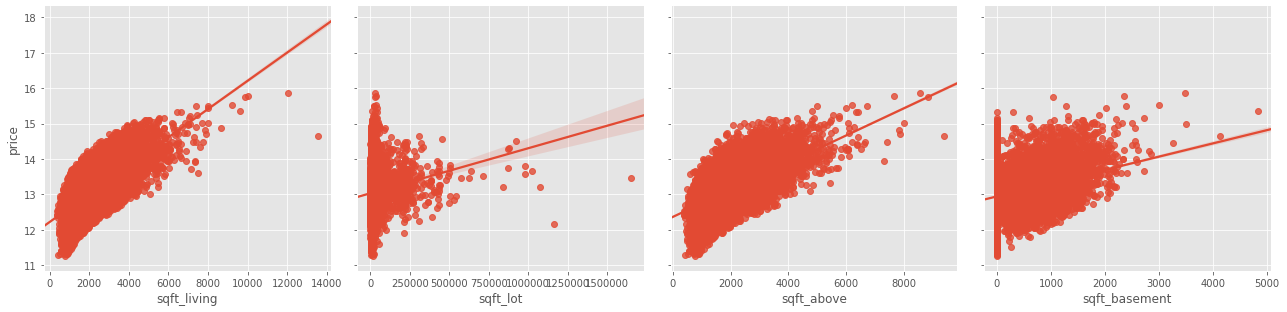

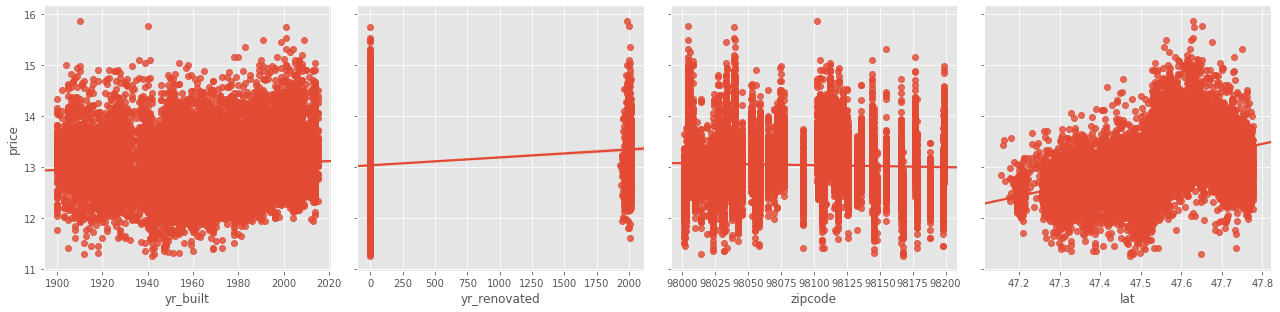

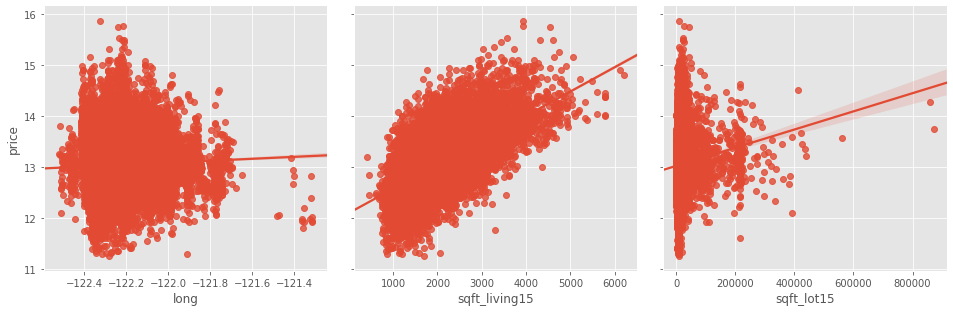

In [45]:
# replot cont vs. price
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [60]:
# remove clear non-linear columns
preprocessed = clean_data.drop(['yr_built', 'yr_renovated', 'zipcode', 'long', 'sqft_lot', 'sqft_lot15'], axis=1)
cont_vars = cont_vars.drop(['yr_built', 'yr_renovated', 'zipcode', 'long', 'sqft_lot', 'sqft_lot15'], axis=1)

KeyError: "['yr_built' 'yr_renovated' 'zipcode' 'long' 'sqft_lot' 'sqft_lot15'] not found in axis"

In [47]:
preprocessed.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'year_sold', 'month_sold', 'day_sold'],
      dtype='object')

In [48]:
cont_vars.columns

Index(['price', 'sqft_living', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15'],
      dtype='object')

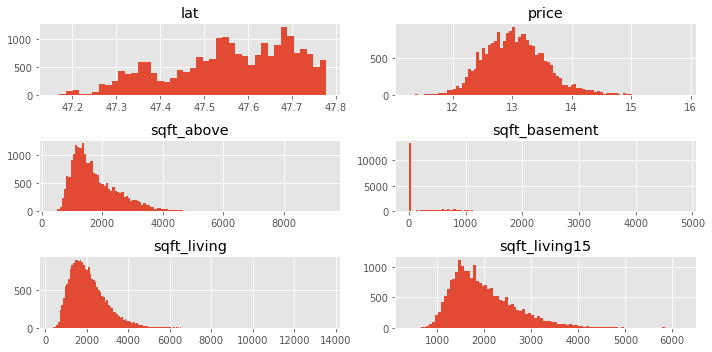

In [49]:
# look at distributions of remaining continuous variables
cont_vars.hist(figsize=(10, 5), bins='auto')
plt.tight_layout()
plt.show()

In [50]:
# log transform sqft_above, sqft_living, sqft_living15 as these look log normally distributed
preprocessed['log_sqft_above'] = np.log(preprocessed['sqft_above'])
preprocessed = preprocessed.drop('sqft_above', axis=1)

In [51]:
preprocessed['log_sqft_living'] = np.log(preprocessed['sqft_living'])
preprocessed = preprocessed.drop('sqft_living', axis=1)

preprocessed['log_sqft_living15'] = np.log(preprocessed['sqft_living15'])
preprocessed = preprocessed.drop('sqft_living15', axis=1)

In [52]:
# replot log transformed variables historgram and against price
log_transformed = preprocessed[['log_sqft_above', 'log_sqft_living', 'log_sqft_living15']]

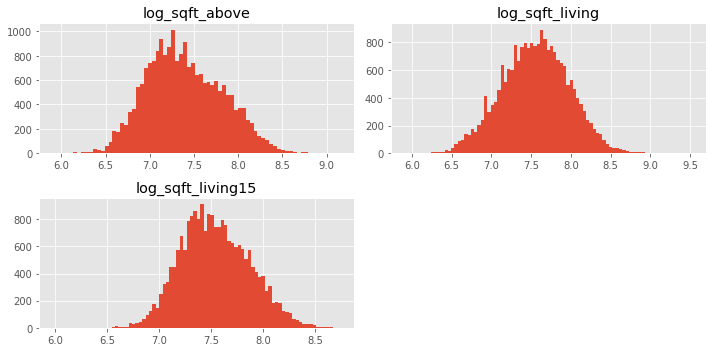

In [53]:
log_transformed.hist(figsize=(10, 5), bins='auto')
plt.tight_layout()
plt.show()

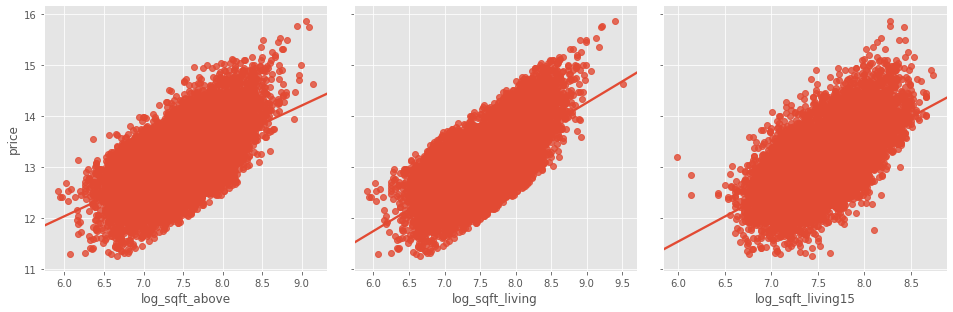

In [54]:
# looking way more normal - - replot against price to see if improved
plot_relationship(data=preprocessed, y_vars=['price'], x_vars=log_transformed.columns)

In [55]:
# looking slightly more linear

In [56]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21597 non-null  float64
 1   bedrooms           21597 non-null  int64  
 2   bathrooms          21597 non-null  float64
 3   floors             21597 non-null  float64
 4   waterfront         21597 non-null  float64
 5   view               21597 non-null  float64
 6   condition          21597 non-null  int64  
 7   grade              21597 non-null  int64  
 8   sqft_basement      21597 non-null  float64
 9   lat                21597 non-null  float64
 10  year_sold          21597 non-null  int64  
 11  month_sold         21597 non-null  int64  
 12  day_sold           21597 non-null  int64  
 13  log_sqft_above     21597 non-null  float64
 14  log_sqft_living    21597 non-null  float64
 15  log_sqft_living15  21597 non-null  float64
dtypes: float64(10), int64(

In [57]:
data_pred = preprocessed.drop('price', axis=1)

In [58]:
# remove multi collinearity
# return only highly correlated pairs
# save absolute value of correlation matrix as data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

#zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

#set index to pairs
df.set_index(['pairs'], inplace=True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [59]:
# get pairs that are more than 75% correlated
df[(df.cc>.75) & (df.cc<1)]

cc
pairs                                      
(log_sqft_living, log_sqft_above)  0.864979
(year_sold, month_sold)            0.782325
(bathrooms, log_sqft_living)       0.762135

In [58]:
# remove log_sqft_above, bathrooms, and 'month'
preprocessed = preprocessed.drop(['log_sqft_above', 'bathrooms', 'month_sold'], axis=1)

In [59]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21597 non-null  float64
 1   bedrooms           21597 non-null  int64  
 2   floors             21597 non-null  float64
 3   waterfront         21597 non-null  float64
 4   view               21597 non-null  float64
 5   condition          21597 non-null  int64  
 6   grade              21597 non-null  int64  
 7   sqft_basement      21597 non-null  float64
 8   lat                21597 non-null  float64
 9   year_sold          21597 non-null  int64  
 10  day_sold           21597 non-null  int64  
 11  log_sqft_living    21597 non-null  float64
 12  log_sqft_living15  21597 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 2.1 MB


In [60]:
log_transformed.columns

Index(['log_sqft_above', 'log_sqft_living', 'log_sqft_living15'], dtype='object')

In [61]:
log_transformed = log_transformed.drop('log_sqft_above', axis=1)

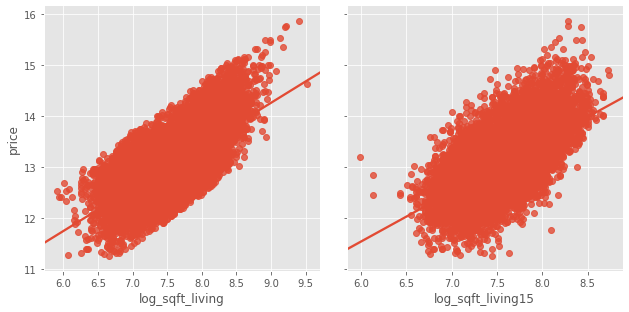

In [62]:
# replot linear
plot_relationship(data=preprocessed, y_vars=['price'], x_vars=log_transformed.columns)

In [63]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21597 non-null  float64
 1   bedrooms           21597 non-null  int64  
 2   floors             21597 non-null  float64
 3   waterfront         21597 non-null  float64
 4   view               21597 non-null  float64
 5   condition          21597 non-null  int64  
 6   grade              21597 non-null  int64  
 7   sqft_basement      21597 non-null  float64
 8   lat                21597 non-null  float64
 9   year_sold          21597 non-null  int64  
 10  day_sold           21597 non-null  int64  
 11  log_sqft_living    21597 non-null  float64
 12  log_sqft_living15  21597 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 2.1 MB


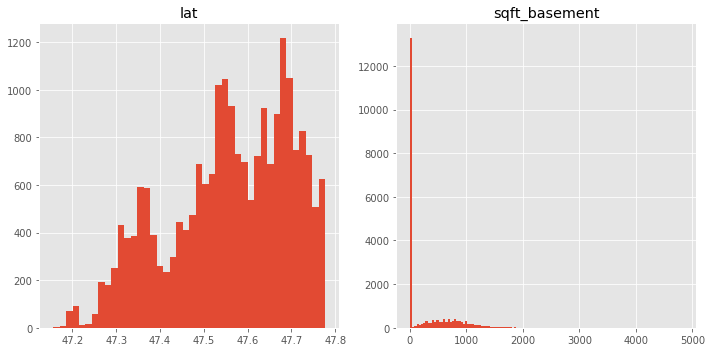

In [64]:
# relationships are looking far more linear now
# handle other continuous variables
remaining_cont = preprocessed[['lat', 'sqft_basement']]
remaining_cont.hist(figsize=(10, 5), bins='auto')
plt.tight_layout()
plt.show()

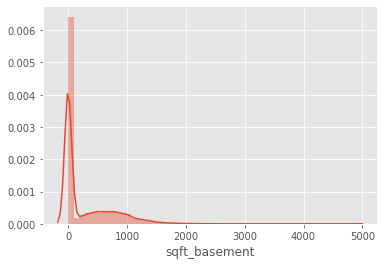

In [65]:
# handle sqft_basement
sns.distplot(preprocessed['sqft_basement'])

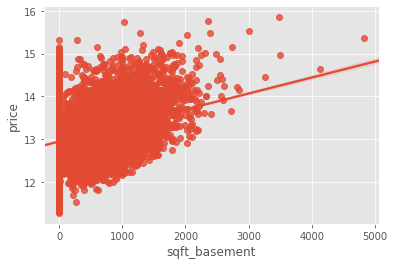

In [66]:
# plot against price
sns.regplot(x='sqft_basement', y='price', data=preprocessed)

In [67]:
# bimodal, with a lot of zeros
# keep in for now, slightly linear
# after baseline model, come back and OHE to see if having a basement is better than not

In [68]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21597 non-null  float64
 1   bedrooms           21597 non-null  int64  
 2   floors             21597 non-null  float64
 3   waterfront         21597 non-null  float64
 4   view               21597 non-null  float64
 5   condition          21597 non-null  int64  
 6   grade              21597 non-null  int64  
 7   sqft_basement      21597 non-null  float64
 8   lat                21597 non-null  float64
 9   year_sold          21597 non-null  int64  
 10  day_sold           21597 non-null  int64  
 11  log_sqft_living    21597 non-null  float64
 12  log_sqft_living15  21597 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 2.1 MB


In [69]:
# cont vars meeting linearity requirement
linearity_requirement = ['log_sqft_living', 'log_sqft_living15', 'lat']

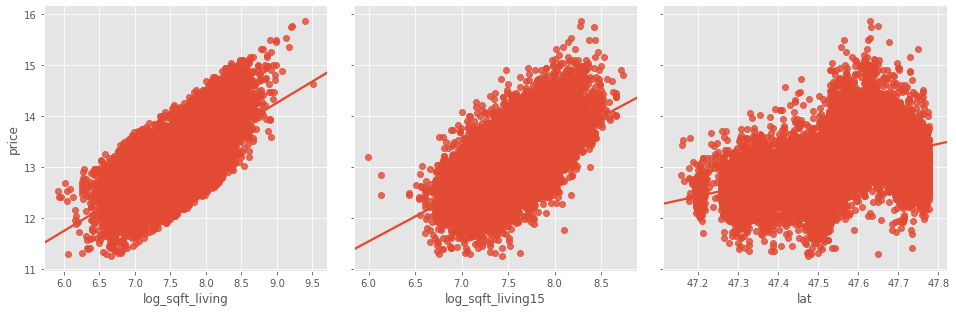

In [70]:
# plot against price to double check linearity
plot_relationship(data=preprocessed, y_vars=['price'], x_vars=linearity_requirement)

In [71]:
# remove lat - - doesn't meet linearity (seems more polynomial), leave all others in for now
preprocessed = preprocessed.drop('lat', axis=1)
linearity_requirement = ['log_sqft_living', 'log_sqft_living15']

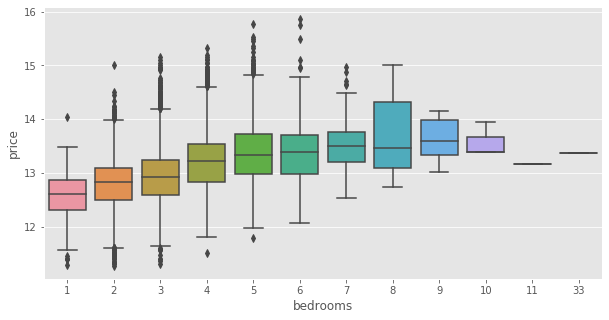

In [72]:
# handle categorical columns
# first will need to identify which categorical columns have an ordinal relationship with price
# plot boxplots of each cat variable to see if it is ordinal or not

# Bedrooms
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='bedrooms', y='price', data=preprocessed)
plt.show()

In [73]:
# there appears to be an ordinal relationship here, leave as single column
# handle outliers
preprocessed['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

In [74]:
# remove outliers
q3 = preprocessed['bedrooms'].quantile(0.75)
q1 = preprocessed['bedrooms'].quantile(0.25)
iqr = q3 - q1
low = q1 - (1.5 * iqr)
high = q3 + (1.5 * iqr)
print(low, high)

1.5 5.5


In [75]:
# remove houses with 1 bedroom, and houses with 6 or more bedrooms
preprocessed = preprocessed.loc[(preprocessed['bedrooms'] > low) & (preprocessed['bedrooms'] < high)]

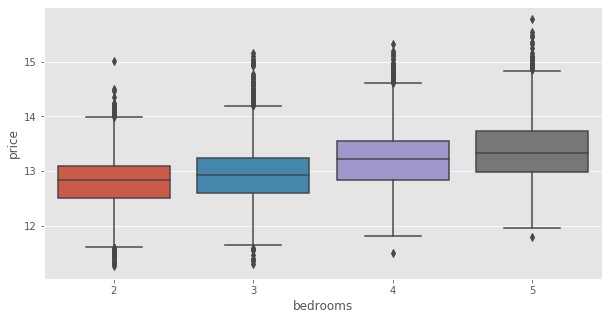

In [76]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='bedrooms', y='price', data=preprocessed)
plt.show()

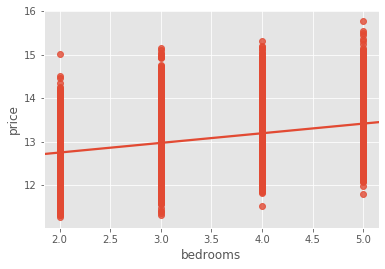

In [77]:
# plot against price without box plots
sns.regplot(x='bedrooms', y='price', data=preprocessed)
plt.show()

In [78]:
# seems ordinal

In [79]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21067 non-null  float64
 1   bedrooms           21067 non-null  int64  
 2   floors             21067 non-null  float64
 3   waterfront         21067 non-null  float64
 4   view               21067 non-null  float64
 5   condition          21067 non-null  int64  
 6   grade              21067 non-null  int64  
 7   sqft_basement      21067 non-null  float64
 8   year_sold          21067 non-null  int64  
 9   day_sold           21067 non-null  int64  
 10  log_sqft_living    21067 non-null  float64
 11  log_sqft_living15  21067 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 2.7 MB


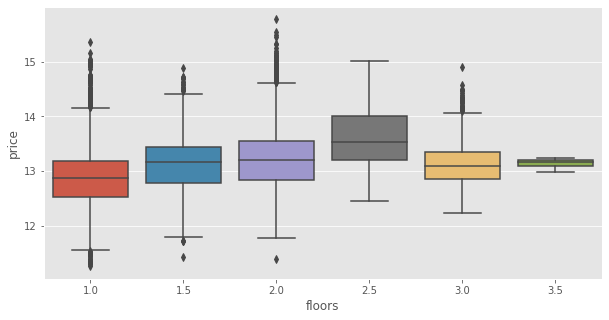

In [80]:
# floors
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='floors', y='price', data=preprocessed)
plt.show()

In [81]:
preprocessed['floors'].describe()

count    21067.000000
mean         1.495063
std          0.539720
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [82]:
# no major outliers -- not ordinal, will OHE

In [83]:
# scale by 10 as 0.0 messes up smf.ols
preprocessed['floors_scaled'] = preprocessed['floors'] * 10

# convert to int
preprocessed['floors_scaled'] = preprocessed['floors_scaled'].astype('int64')

In [84]:
ohe_list = []
ohe_list.append('floors')

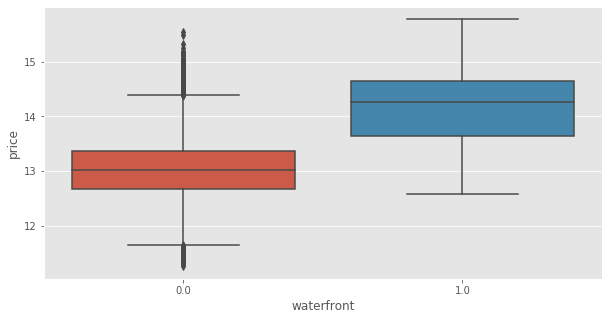

In [85]:
# waterfront
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='waterfront', y='price', data=preprocessed)
plt.show()

In [86]:
# convert to int to avoid syntax issues with smf.ols
preprocessed['waterfront_clean'] = preprocessed['waterfront'].astype('int64')

# drop waterfront column
preprocessed = preprocessed.drop('waterfront', axis=1)

In [87]:
# CREATE DUMMY
ohe_list.append('waterfront_clean')

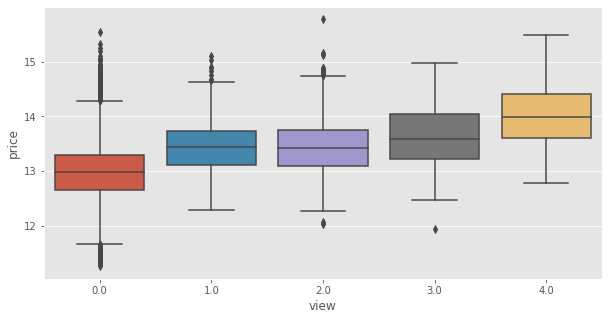

In [88]:
# view
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='view', y='price', data=preprocessed)
plt.show()

In [89]:
# convert to int
preprocessed['view'] = preprocessed['view'].astype('int64')

In [90]:
# slight ordinal relationship, leave as a single column for now
preprocessed['view'].describe()

count    21067.000000
mean         0.228746
std          0.756273
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

In [91]:
# remove outliers
q3 = preprocessed['view'].quantile(0.75)
q1 = preprocessed['view'].quantile(0.25)
iqr = q3 - q1
low = q1 - (1.5 * iqr)
high = q3 + (1.5 * iqr)
print(low, high)

0.0 0.0


In [92]:
#OHE
ohe_list.append('view')

In [93]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21067 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21067 non-null  float64
 1   bedrooms           21067 non-null  int64  
 2   floors             21067 non-null  float64
 3   view               21067 non-null  int64  
 4   condition          21067 non-null  int64  
 5   grade              21067 non-null  int64  
 6   sqft_basement      21067 non-null  float64
 7   year_sold          21067 non-null  int64  
 8   day_sold           21067 non-null  int64  
 9   log_sqft_living    21067 non-null  float64
 10  log_sqft_living15  21067 non-null  float64
 11  floors_scaled      21067 non-null  int64  
 12  waterfront_clean   21067 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 2.9 MB


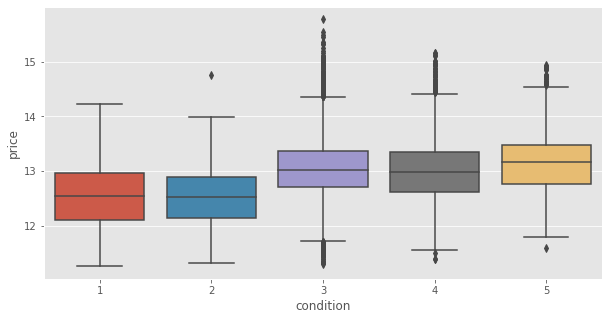

In [94]:
# condition
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='condition', y='price', data=preprocessed)
plt.show()

In [95]:
# no clear ordinal relationship
# CREATE DUMMY
ohe_list.append('condition')

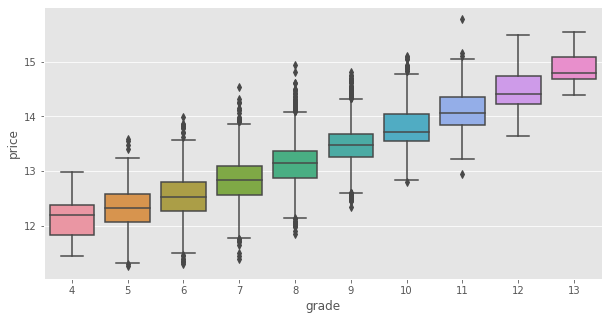

In [96]:
# grade
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='grade', y='price', data=preprocessed)
plt.show()

In [97]:
# clear ordinal relationship
# look at outliers
preprocessed['grade'].describe()

count    21067.000000
mean         7.665021
std          1.159440
min          4.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

In [98]:
# remove outliers
q3 = preprocessed['grade'].quantile(0.75)
q1 = preprocessed['grade'].quantile(0.25)
iqr = q3 - q1
low = q1 - (1.5 * iqr)
high = q3 + (1.5 * iqr)
print(low, high)

5.5 9.5


In [99]:
preprocessed = preprocessed.loc[(preprocessed['grade'] > low) & (preprocessed['grade'] < high)]

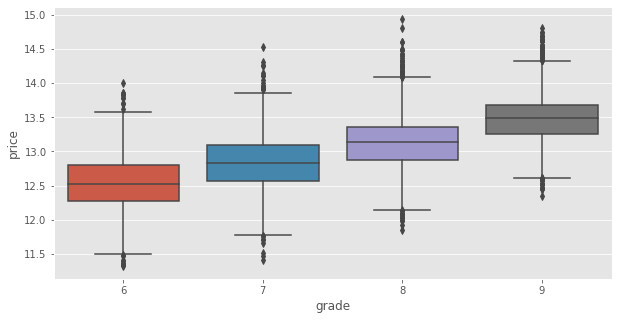

In [100]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='grade', y='price', data=preprocessed)
plt.show()

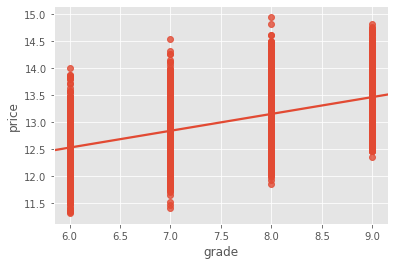

In [101]:
# leaving this as a single column
sns.regplot(x='grade', y='price', data=preprocessed)

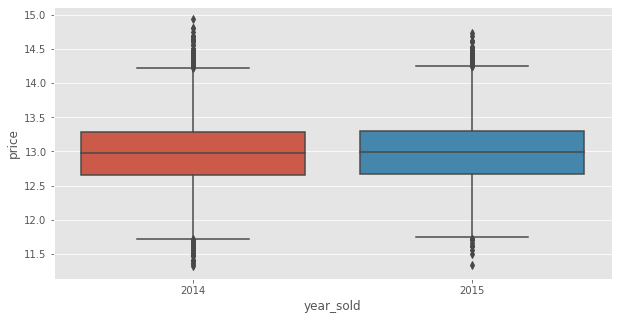

In [102]:
# year_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='year_sold', y='price', data=preprocessed)
plt.show()

In [103]:
# OHE
ohe_list.append('year_sold')

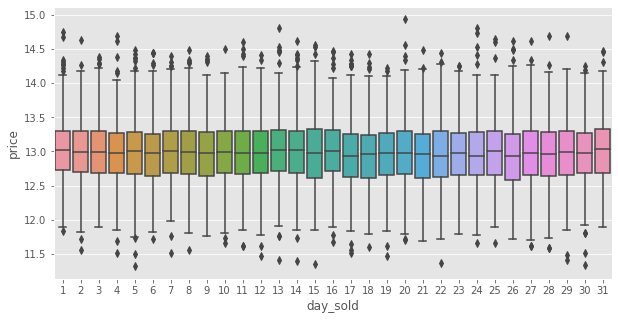

In [104]:
# day_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='day_sold', y='price', data=preprocessed)
plt.show()

In [105]:
# OHE
ohe_list.append('day_sold')

In [106]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19270 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              19270 non-null  float64
 1   bedrooms           19270 non-null  int64  
 2   floors             19270 non-null  float64
 3   view               19270 non-null  int64  
 4   condition          19270 non-null  int64  
 5   grade              19270 non-null  int64  
 6   sqft_basement      19270 non-null  float64
 7   year_sold          19270 non-null  int64  
 8   day_sold           19270 non-null  int64  
 9   log_sqft_living    19270 non-null  float64
 10  log_sqft_living15  19270 non-null  float64
 11  floors_scaled      19270 non-null  int64  
 12  waterfront_clean   19270 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 2.7 MB


In [107]:
ohe_list

['floors', 'waterfront_clean', 'view', 'condition', 'year_sold', 'day_sold']

In [108]:
floor_dummies = pd.get_dummies(preprocessed['floors_scaled'], prefix='floors', drop_first=True)
waterfront_dummies = pd.get_dummies(preprocessed['waterfront_clean'], prefix='waterfront', drop_first=True)
view_dummies = pd.get_dummies(preprocessed['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(preprocessed['condition'], prefix='condition', drop_first=True)
year_sold_dummies = pd.get_dummies(preprocessed['year_sold'], prefix='year_sold', drop_first=True)
day_sold_dummies = pd.get_dummies(preprocessed['day_sold'], prefix='day_sold', drop_first=True)

In [109]:
# concat with dummies and drop cat columns
data_fin = pd.concat([preprocessed, floor_dummies, waterfront_dummies,
                      condition_dummies, year_sold_dummies, day_sold_dummies, view_dummies], axis=1)

In [110]:
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19270 entries, 0 to 21596
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              19270 non-null  float64
 1   bedrooms           19270 non-null  int64  
 2   floors             19270 non-null  float64
 3   view               19270 non-null  int64  
 4   condition          19270 non-null  int64  
 5   grade              19270 non-null  int64  
 6   sqft_basement      19270 non-null  float64
 7   year_sold          19270 non-null  int64  
 8   day_sold           19270 non-null  int64  
 9   log_sqft_living    19270 non-null  float64
 10  log_sqft_living15  19270 non-null  float64
 11  floors_scaled      19270 non-null  int64  
 12  waterfront_clean   19270 non-null  int64  
 13  floors_15          19270 non-null  uint8  
 14  floors_20          19270 non-null  uint8  
 15  floors_25          19270 non-null  uint8  
 16  floors_30          192

In [111]:
data_fin = data_fin.drop(['day_sold', 'condition', 'waterfront_clean', 'floors', 'floors_scaled', 'view'], axis=1)

In [112]:
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19270 entries, 0 to 21596
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              19270 non-null  float64
 1   bedrooms           19270 non-null  int64  
 2   grade              19270 non-null  int64  
 3   sqft_basement      19270 non-null  float64
 4   year_sold          19270 non-null  int64  
 5   log_sqft_living    19270 non-null  float64
 6   log_sqft_living15  19270 non-null  float64
 7   floors_15          19270 non-null  uint8  
 8   floors_20          19270 non-null  uint8  
 9   floors_25          19270 non-null  uint8  
 10  floors_30          19270 non-null  uint8  
 11  floors_35          19270 non-null  uint8  
 12  waterfront_1       19270 non-null  uint8  
 13  condition_2        19270 non-null  uint8  
 14  condition_3        19270 non-null  uint8  
 15  condition_4        19270 non-null  uint8  
 16  condition_5        192

In [113]:
# run stepwise selection to select features
y = data_fin['price']
X = data_fin.drop('price', axis=1)

result = stepwise_selection(X, y, verbose = True)

Add  bedrooms                       with p-value 0.0


/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  log_sqft_living15              with p-value 0.0
Add  grade                          with p-value 0.0
Add  sqft_basement                  with p-value 1.12276e-264
Drop bedrooms                       with p-value 0.61399
Add  floors_15                      with p-value 9.8352e-184
Add  condition_5                    with p-value 1.10107e-71
Add  waterfront_1                   with p-value 2.0868e-57
Add  log_sqft_living                with p-value 2.18311e-50
Add  bedrooms                       with p-value 7.00535e-37
Add  floors_30                      with p-value 7.25715e-29
Add  condition_4                    with p-value 5.4598e-29
Add  view_2                         with p-value 1.93935e-21
Add  view_4                         with p-value 2.25253e-19
Add  view_1                         with p-value 8.88387e-20
Add  view_3                         with p-value 7.78948e-18
Add  year_sold                      with p-value 3.93007e-14
Add  floors_25                      with p-va

In [114]:
result

['log_sqft_living15',
 'grade',
 'sqft_basement',
 'floors_15',
 'condition_5',
 'waterfront_1',
 'log_sqft_living',
 'bedrooms',
 'floors_30',
 'condition_4',
 'view_2',
 'view_4',
 'view_1',
 'view_3',
 'year_sold',
 'floors_25',
 'year_sold_2015',
 'condition_3',
 'floors_20',
 'day_sold_26',
 'day_sold_31']

In [115]:
# run regression with these features
X = data_fin[result]
y = data_fin['price']
predictors = sm.add_constant(X)

model = sm.OLS(y, predictors).fit()

In [116]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     935.2
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:36:03   Log-Likelihood:                -5592.8
No. Observations:               19270   AIC:                         1.123e+04
Df Residuals:                   19249   BIC:                         1.139e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.55e-05   2.48e-06     -6.251      0.000   -2.04e-05   -1.06e-05
log_sqft_living15     0.2502      0.012     20.671      0.000       0.226       0.274
grade                 0.1936      0.004     47.011      0.000       0.186       0.202
sqft_basement         0.0001   7.78e-06     18.385      0.000       0.000       0.000
floors_15             0.2294      0.009     26.547      0.000       0.212       0.246
condition_5           0.3092      0.027     11.360      0.000       0.256       0.363
waterfront_1          0.3214      0.043      7.390      0.000       0.236       0.407
log_sqft_living       0.2389      0.013     17.972      0.000       0.213       0.265
bedrooms             -0.0446      0.004    -11.620      0.000      -0.052      -0.037
floors_30             0.1899      0.015     12.648      0.000       0.161       0.219
condition_4           0.1847      0.026      7.025      0.000       0.133       0.236
view_2                0.1329      0.012     10.831      0.000       0.109       0.157
view_4                0.2940      0.030      9.888      0.000       0.236       0.352
view_1                0.1921      0.020      9.640      0.000       0.153       0.231
view_3                0.1530      0.018      8.655      0.000       0.118       0.188
year_sold             0.0039   4.15e-05     92.862      0.000       0.004       0.004
floors_25             0.2557      0.032      8.054      0.000       0.193       0.318
year_sold_2015        0.0351      0.005      7.024      0.000       0.025       0.045
condition_3           0.1214      0.026      4.644      0.000       0.070       0.173
floors_20             0.0310      0.007      4.487      0.000       0.017       0.044
day_sold_26          -0.0500      0.013     -3.729      0.000      -0.076      -0.024
day_sold_31           0.0619      0.022      2.856      0.004       0.019       0.104
==============================================================================
Omnibus:                        4.260   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                4.108
Skew:                           0.013   Prob(JB):                        0.128
Kurtosis:                       2.933   Cond. No.                     2.97e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.05e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~price
-------------------------------------------------------------------------------------


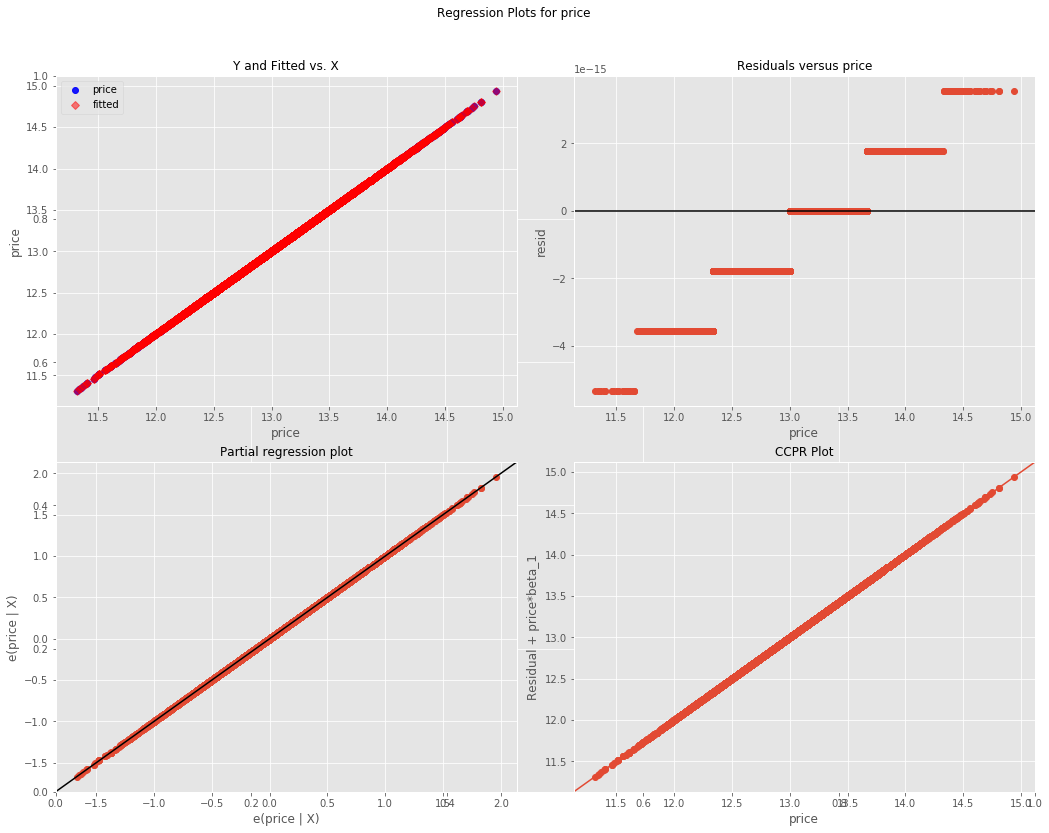

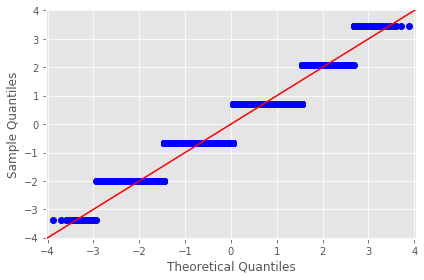

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~log_sqft_living15
-------------------------------------------------------------------------------------


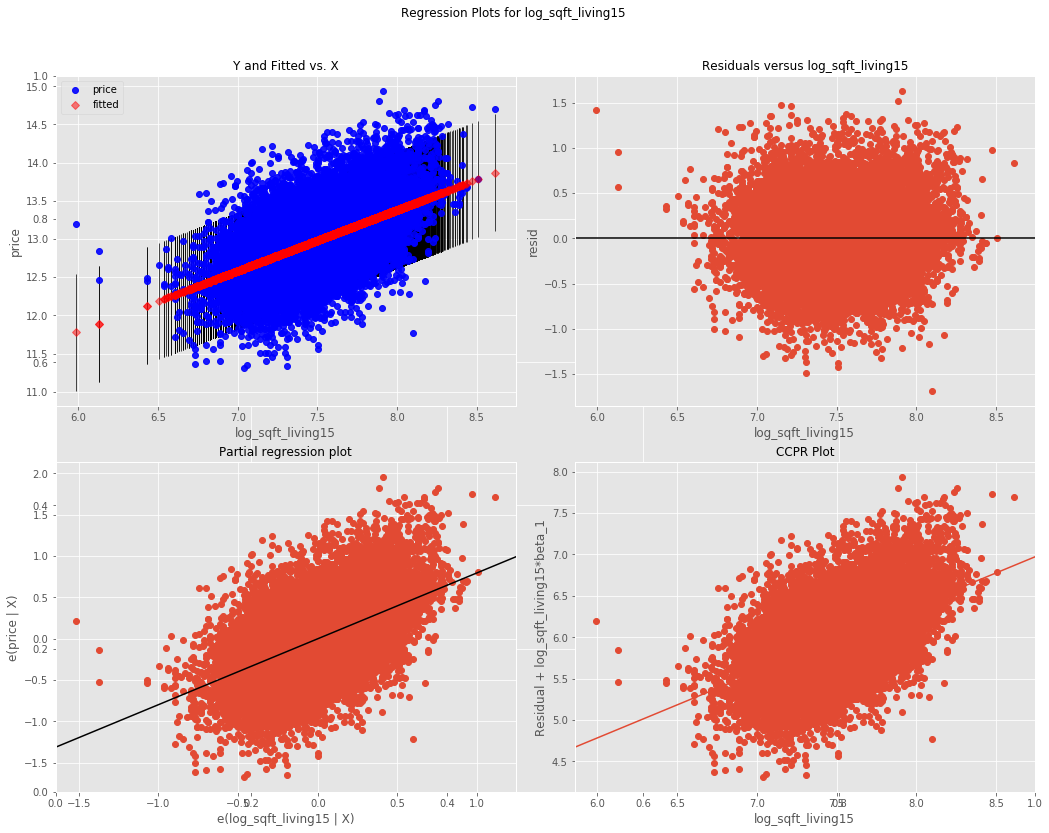

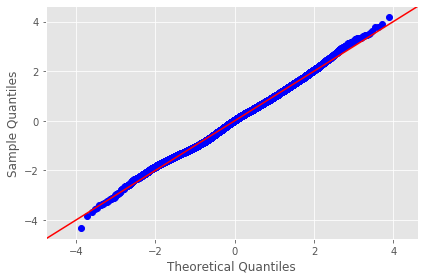

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~grade
-------------------------------------------------------------------------------------


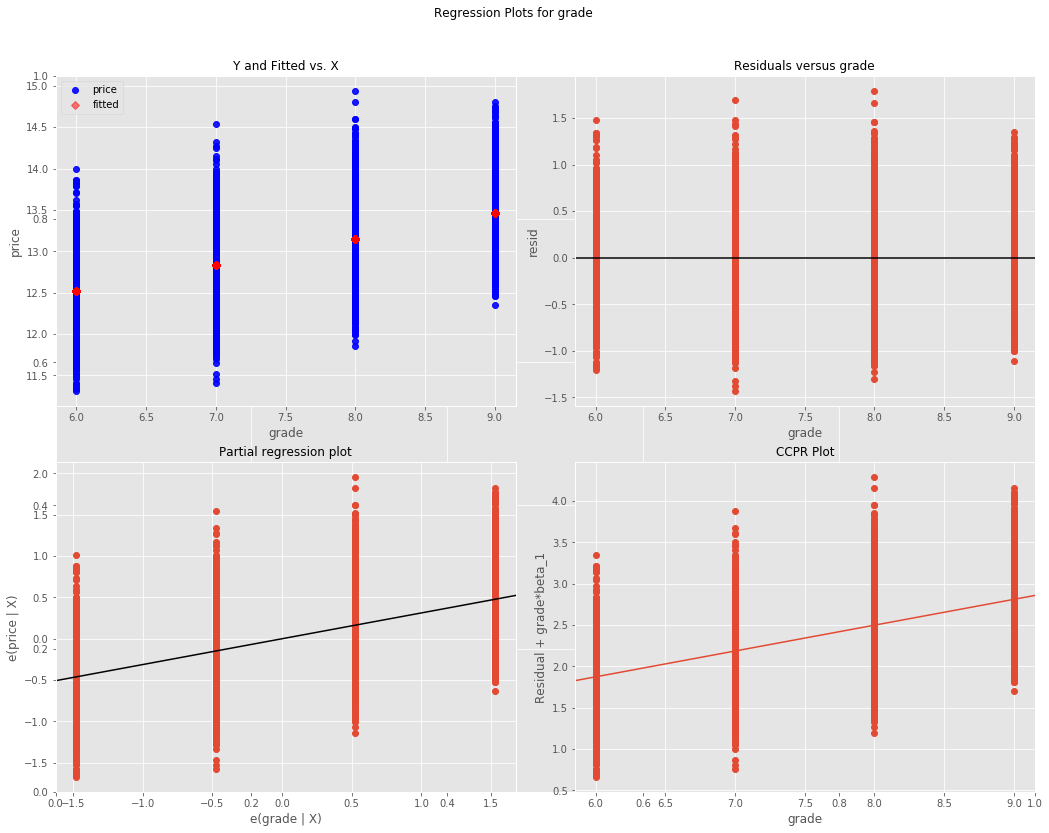

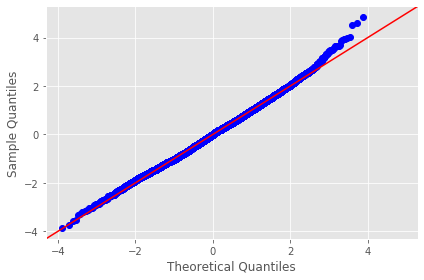

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_basement
-------------------------------------------------------------------------------------


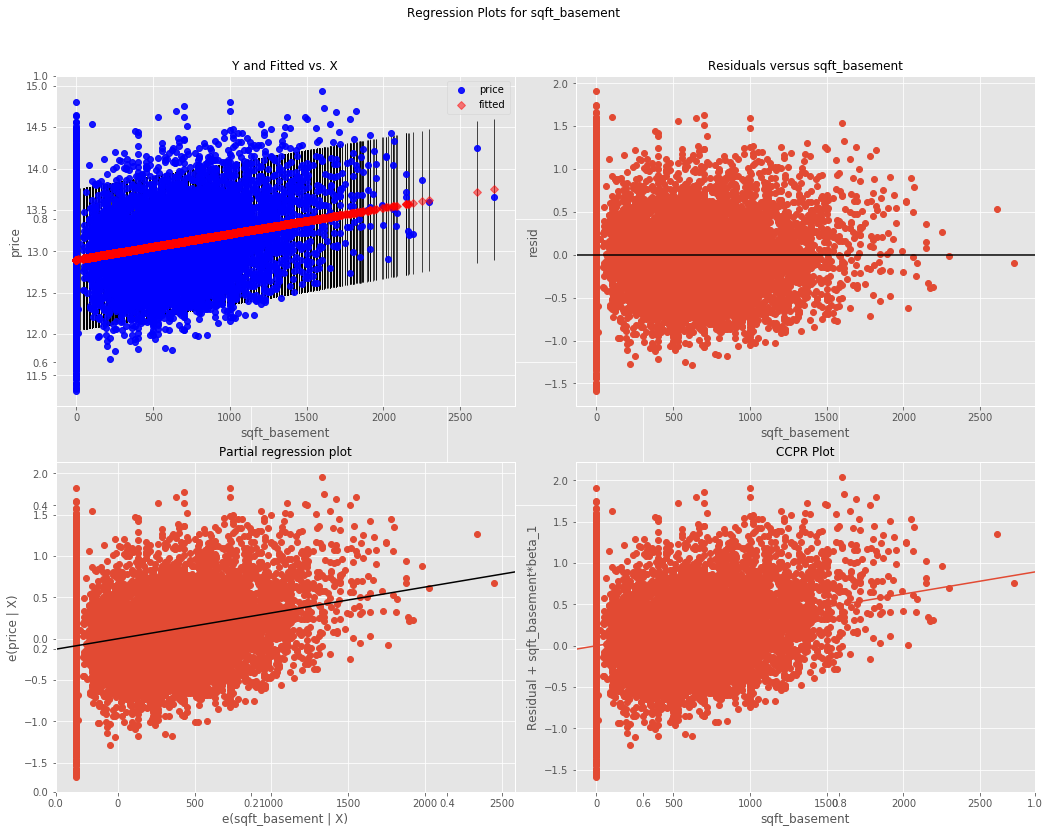

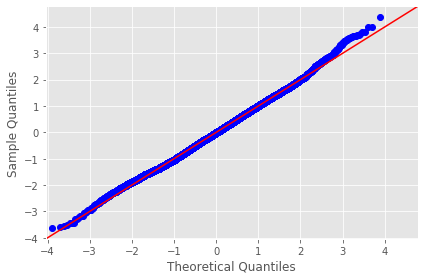

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_15
-------------------------------------------------------------------------------------


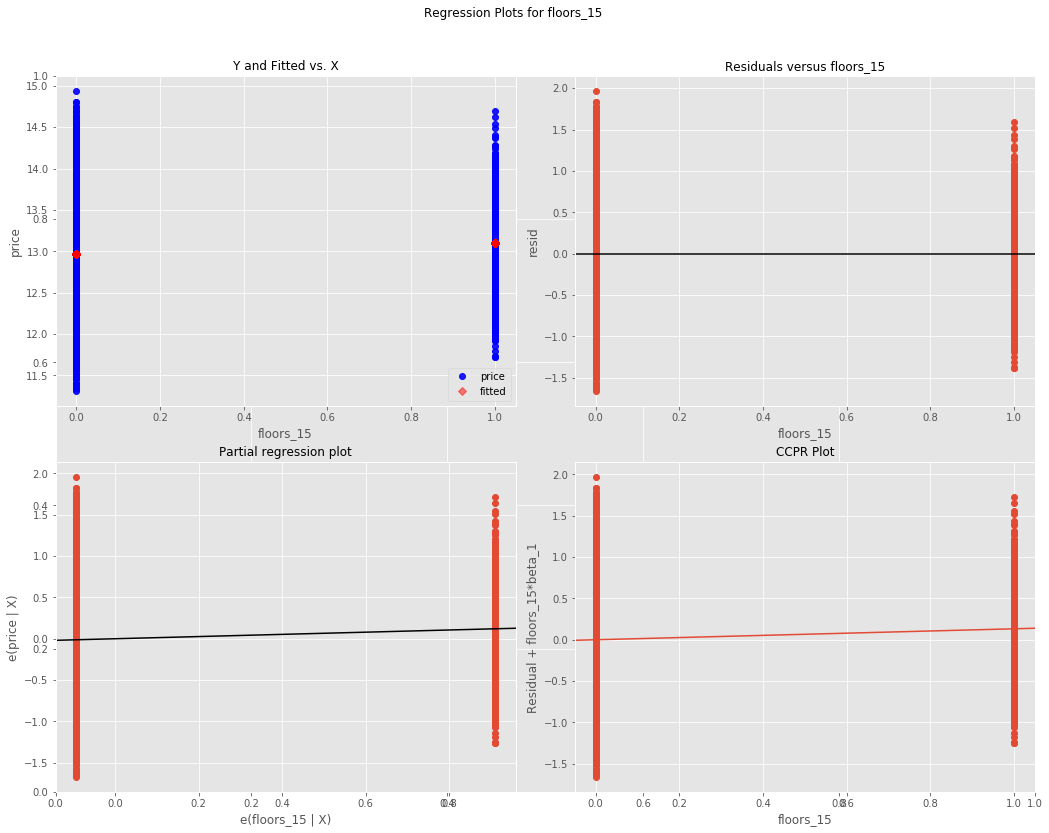

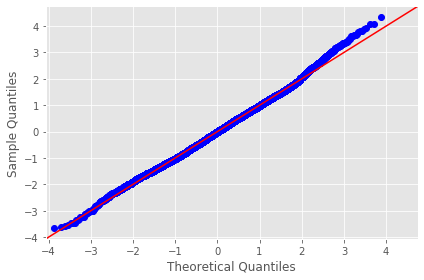

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_5
-------------------------------------------------------------------------------------


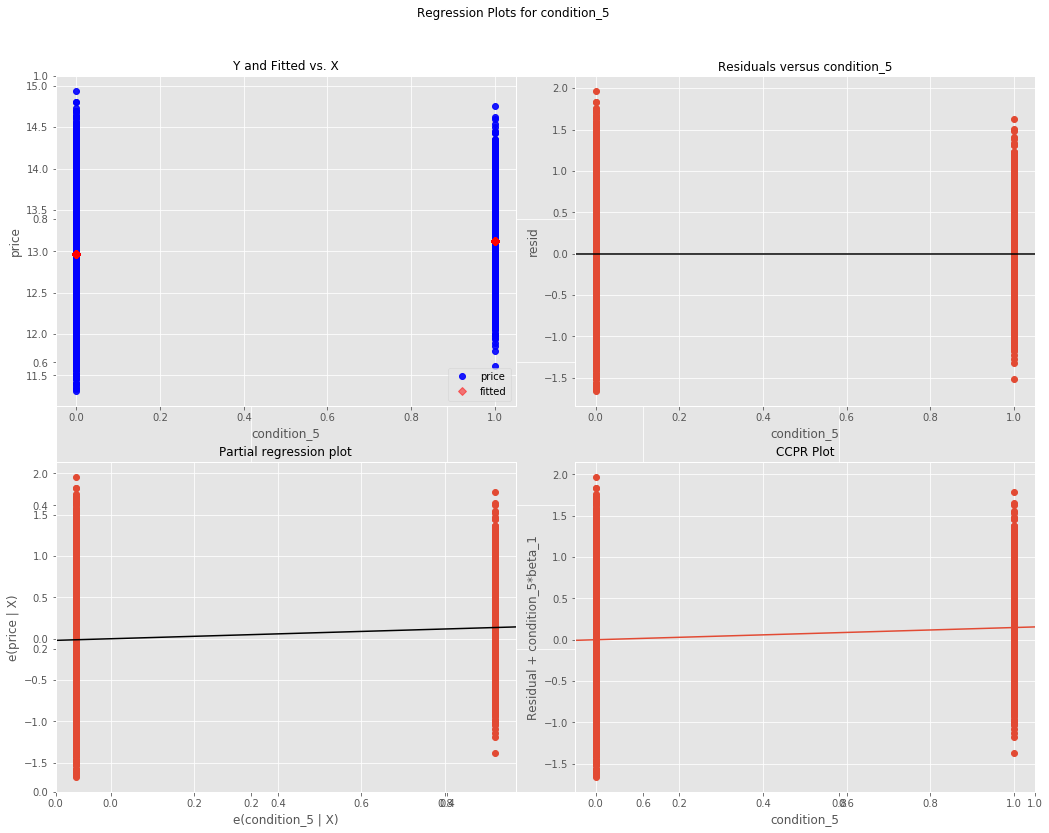

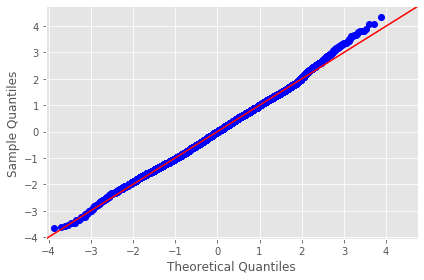

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~waterfront_1
-------------------------------------------------------------------------------------


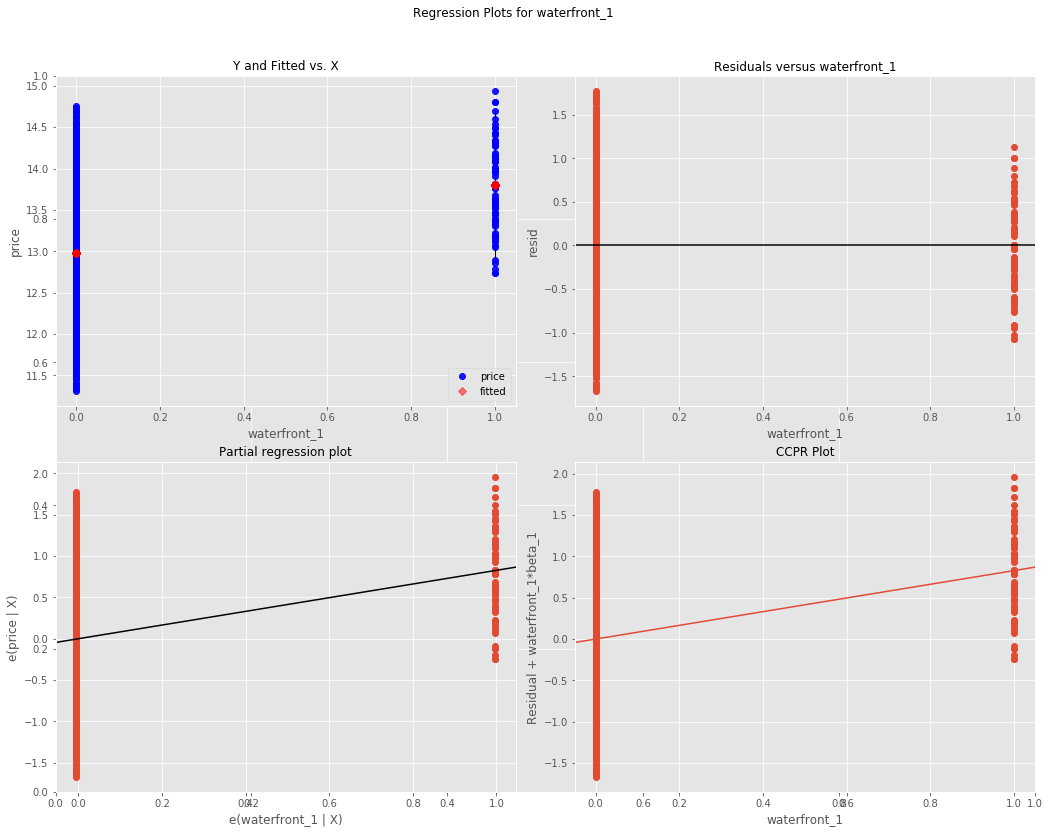

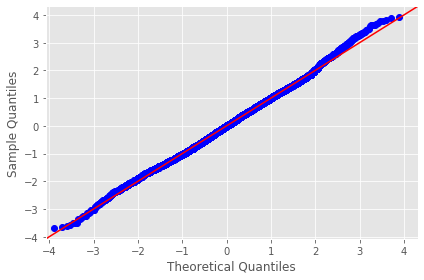

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~log_sqft_living
-------------------------------------------------------------------------------------


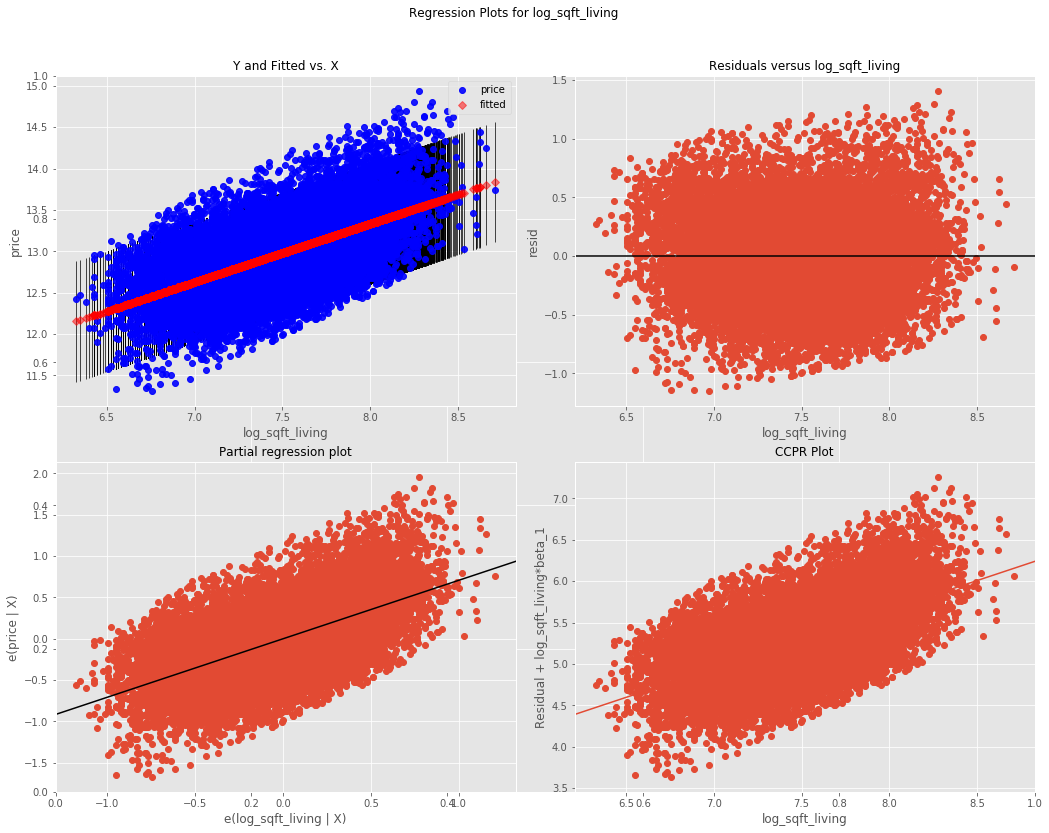

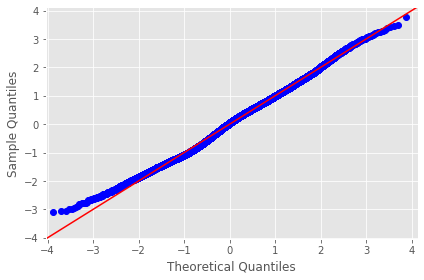

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~bedrooms
-------------------------------------------------------------------------------------


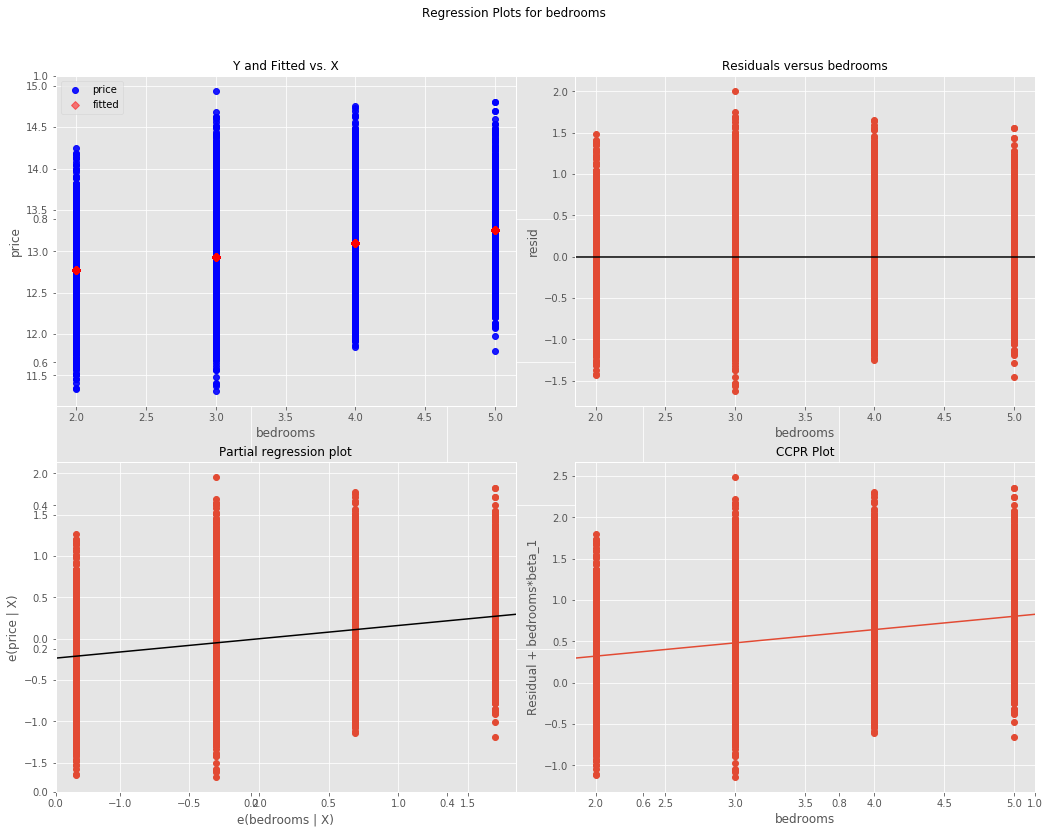

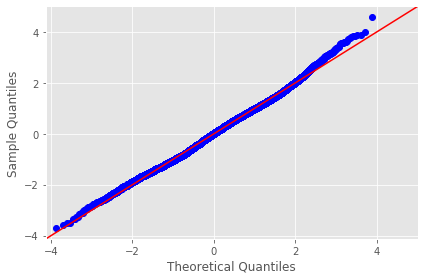

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_30
-------------------------------------------------------------------------------------


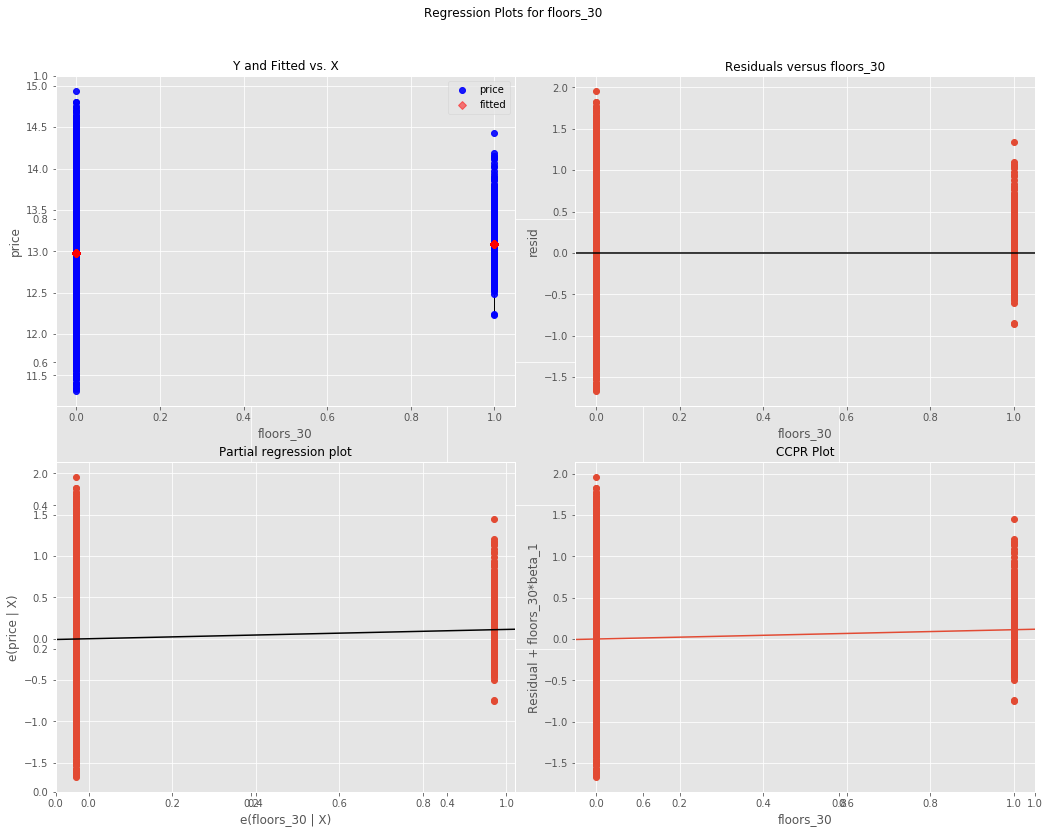

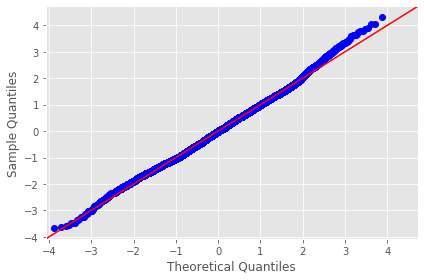

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_4
-------------------------------------------------------------------------------------


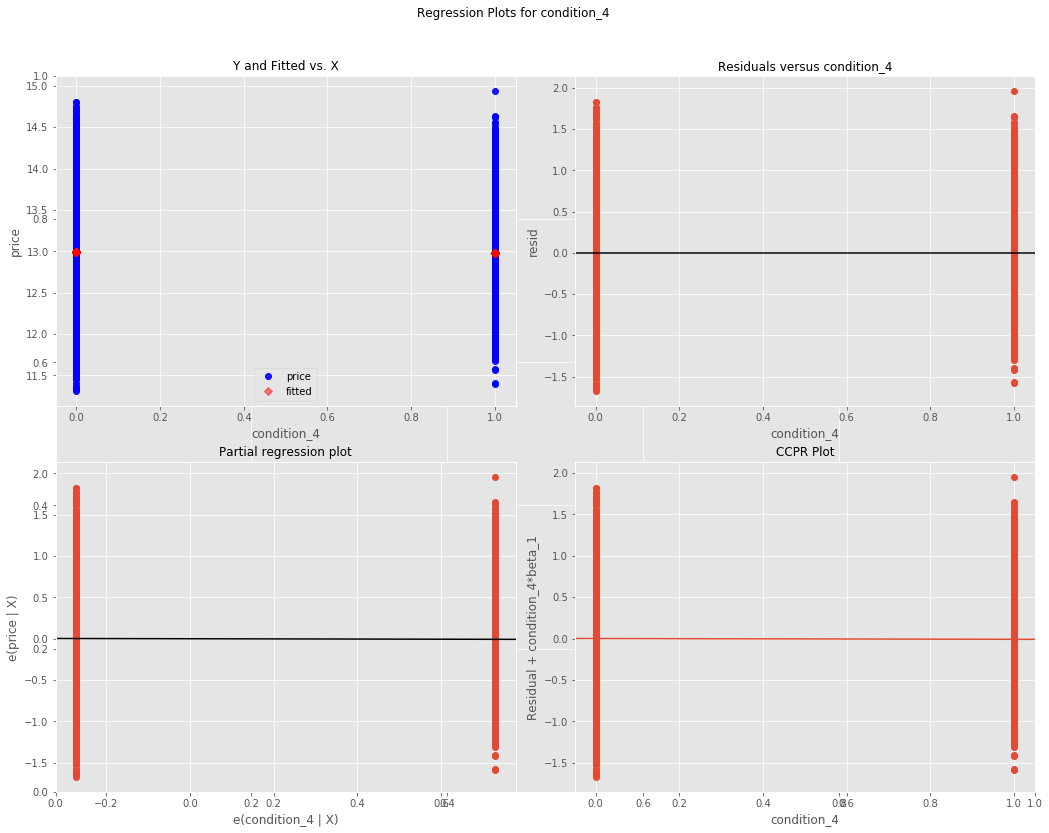

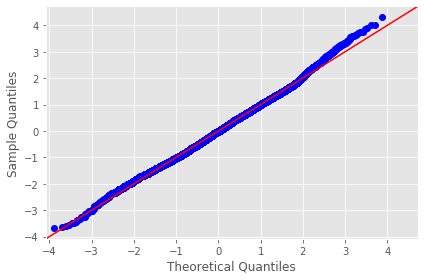

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view_2
-------------------------------------------------------------------------------------


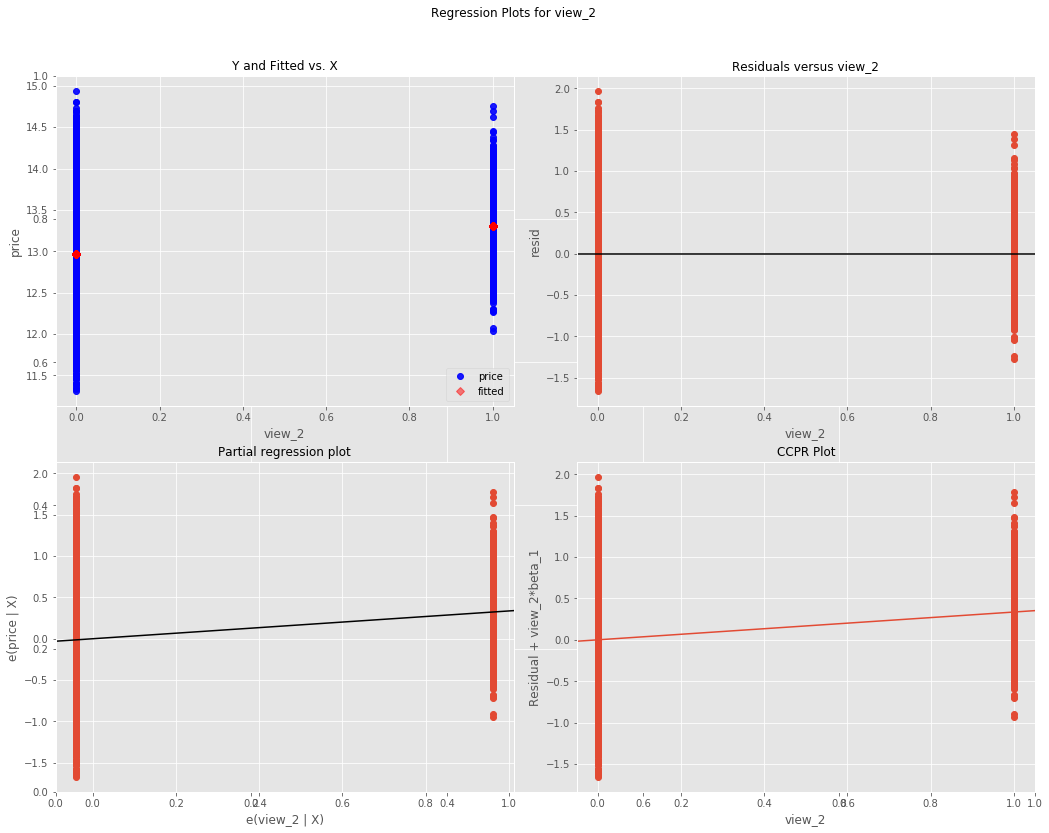

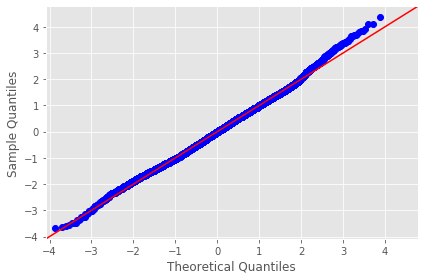

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view_4
-------------------------------------------------------------------------------------


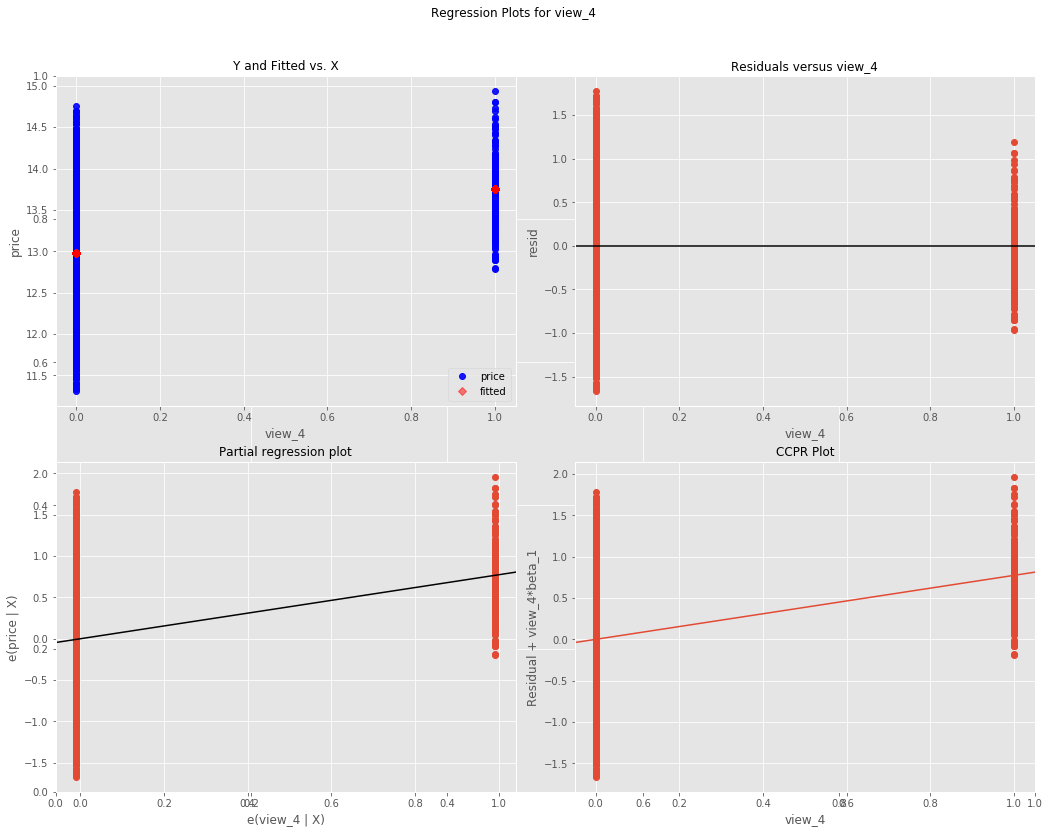

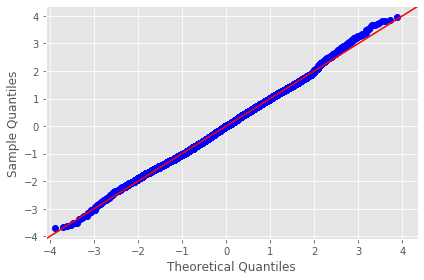

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view_1
-------------------------------------------------------------------------------------


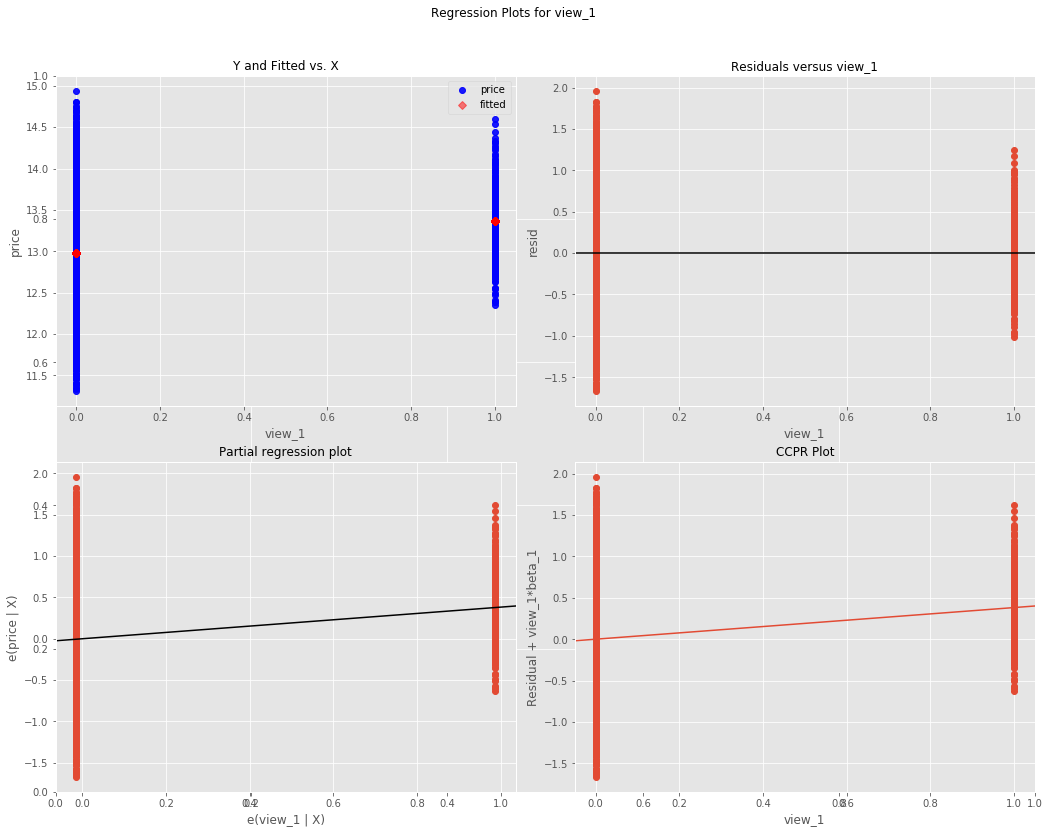

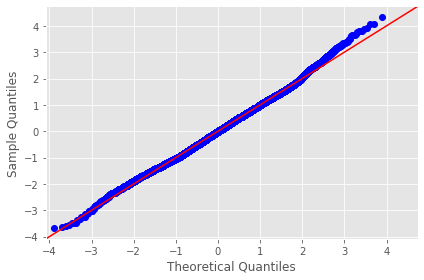

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view_3
-------------------------------------------------------------------------------------


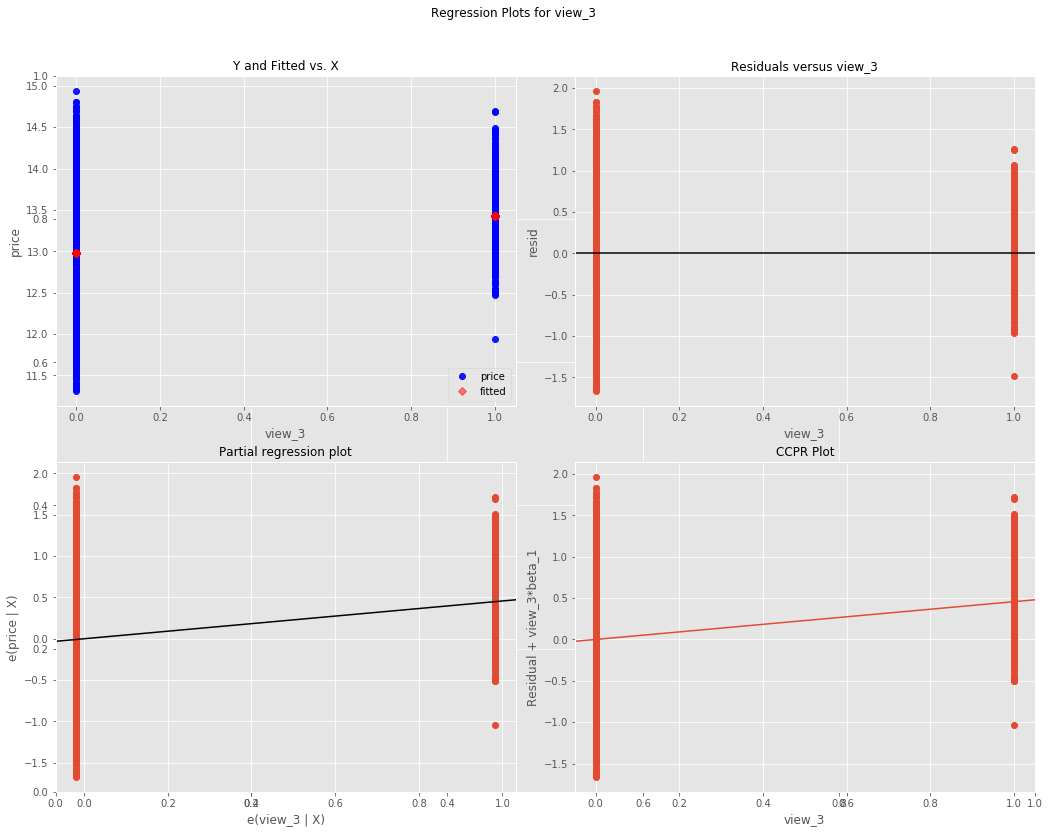

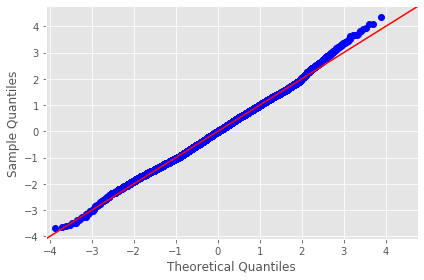

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~year_sold
-------------------------------------------------------------------------------------


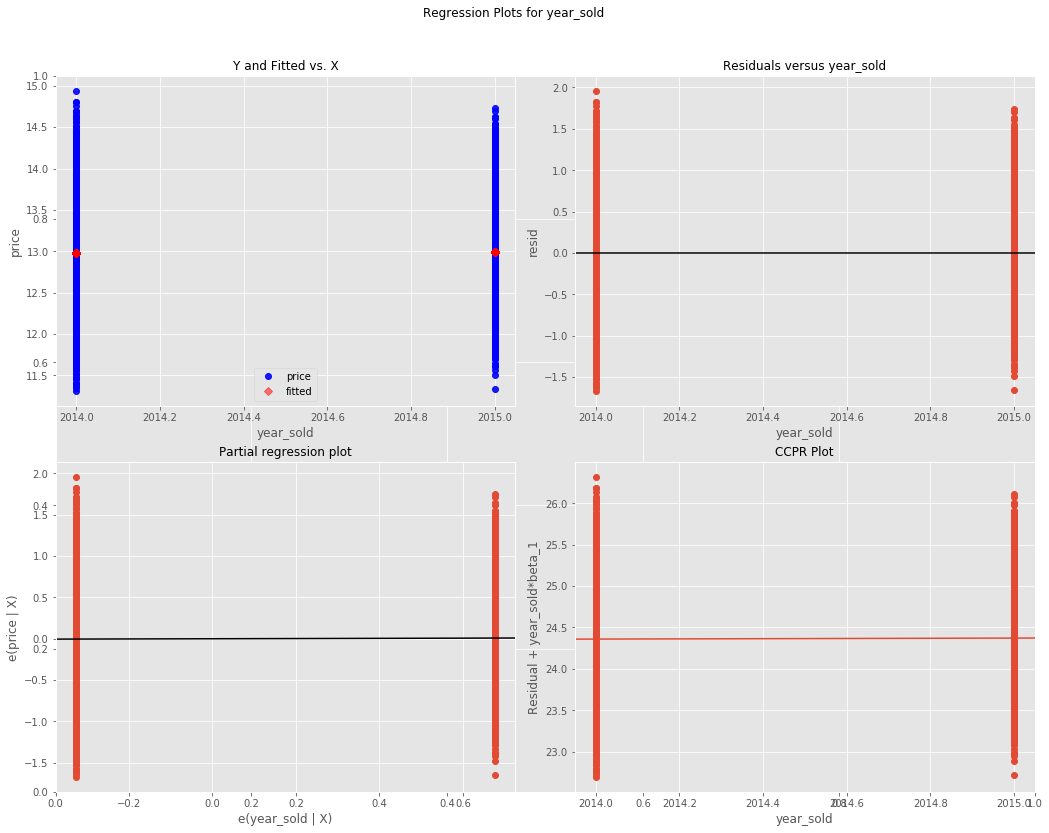

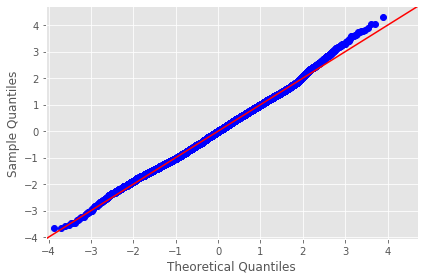

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_25
-------------------------------------------------------------------------------------


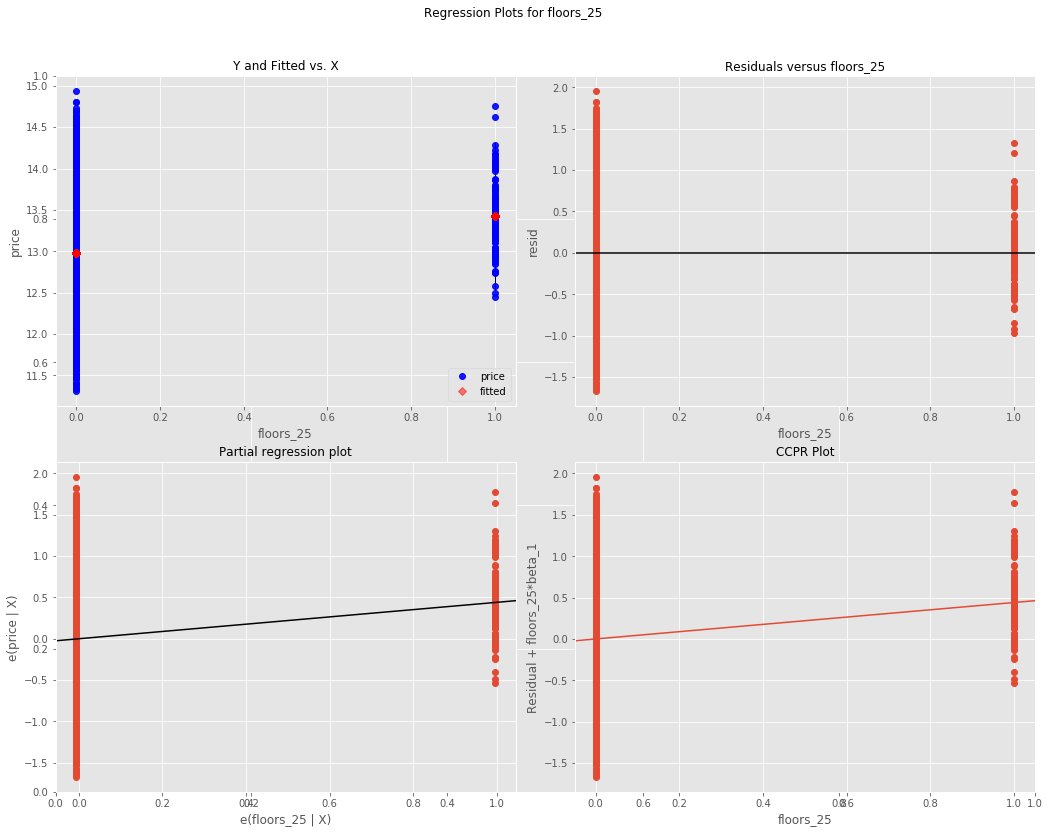

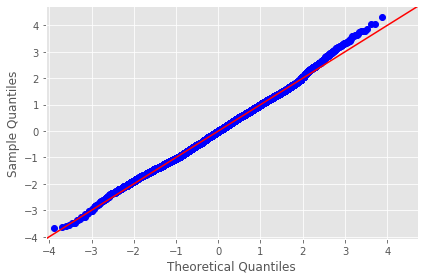

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~year_sold_2015
-------------------------------------------------------------------------------------


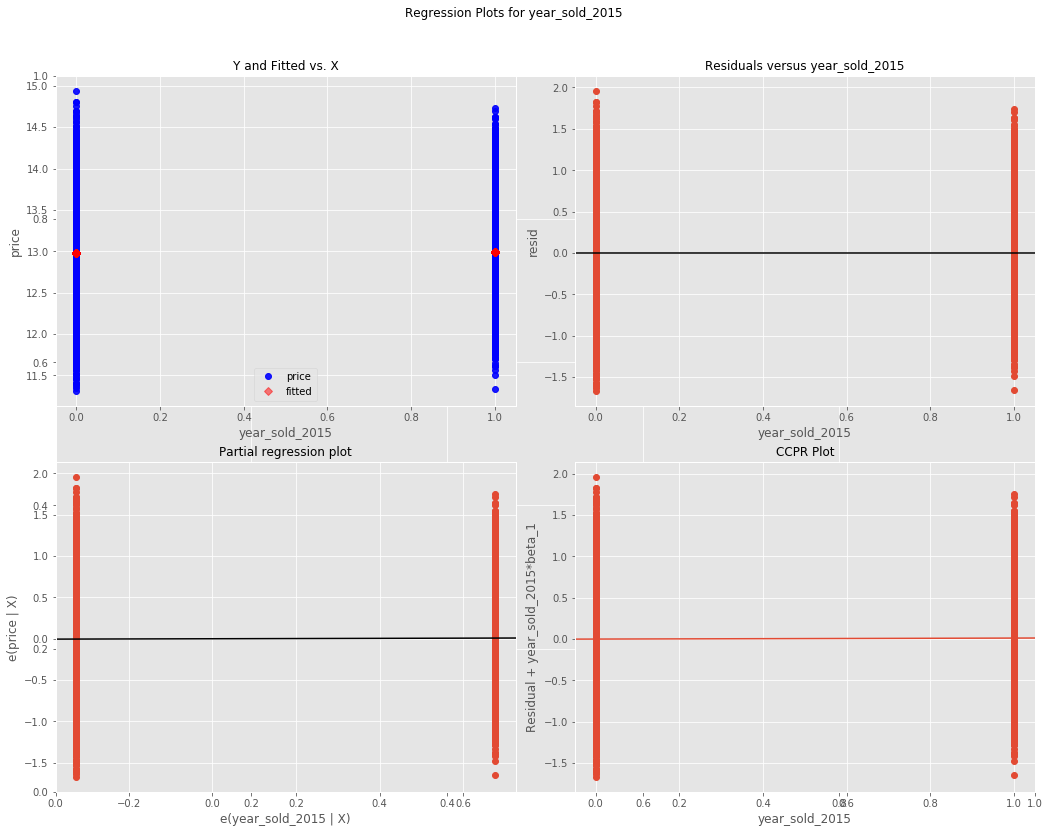

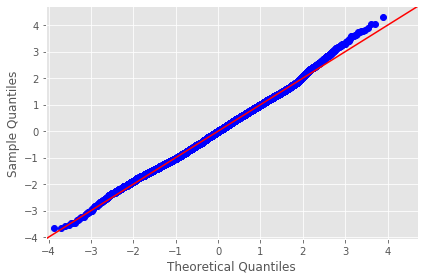

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_3
-------------------------------------------------------------------------------------


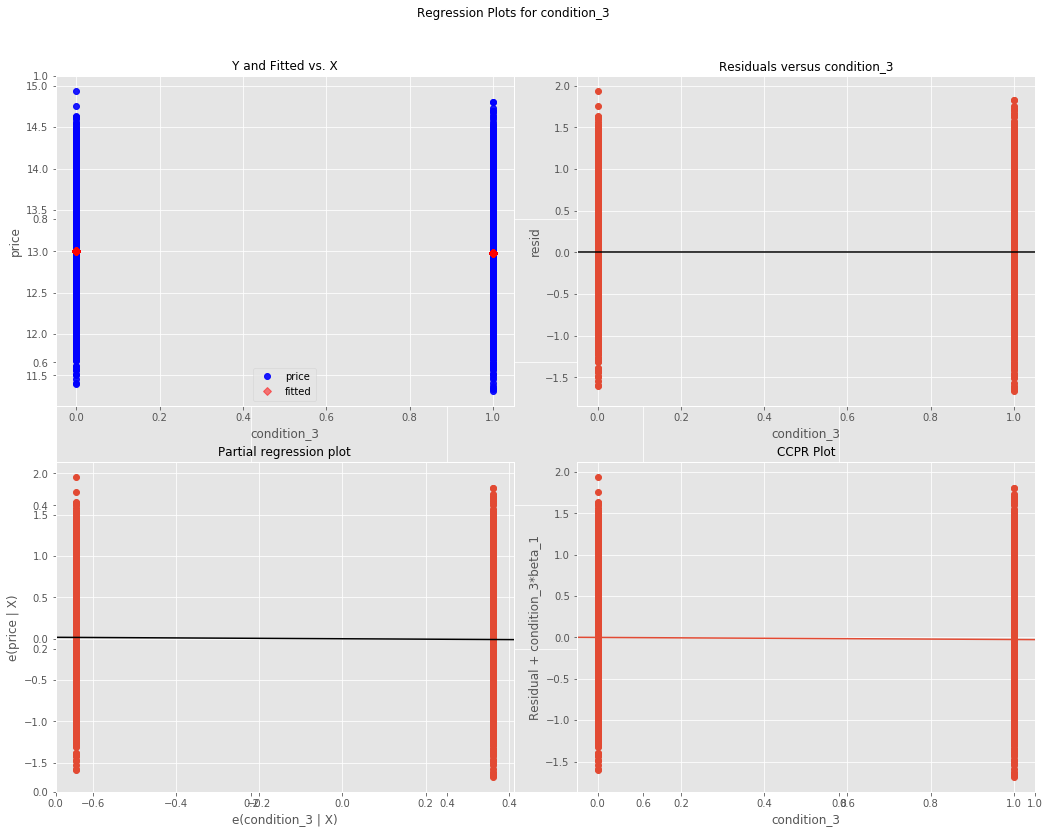

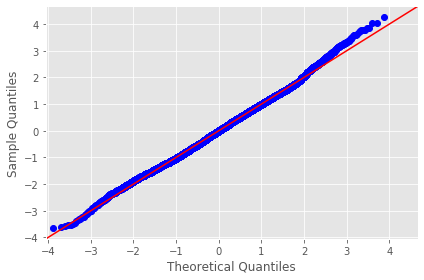

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_20
-------------------------------------------------------------------------------------


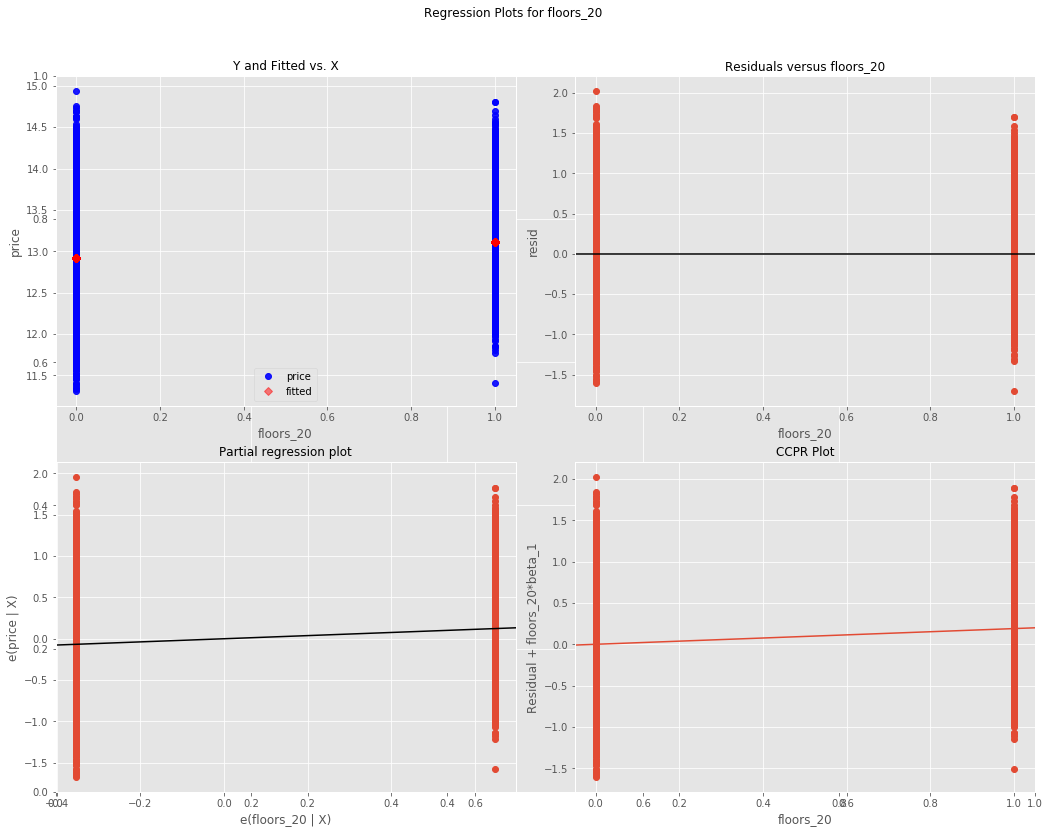

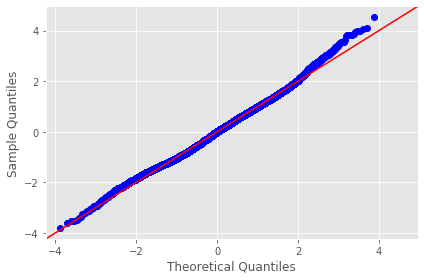

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_26
-------------------------------------------------------------------------------------


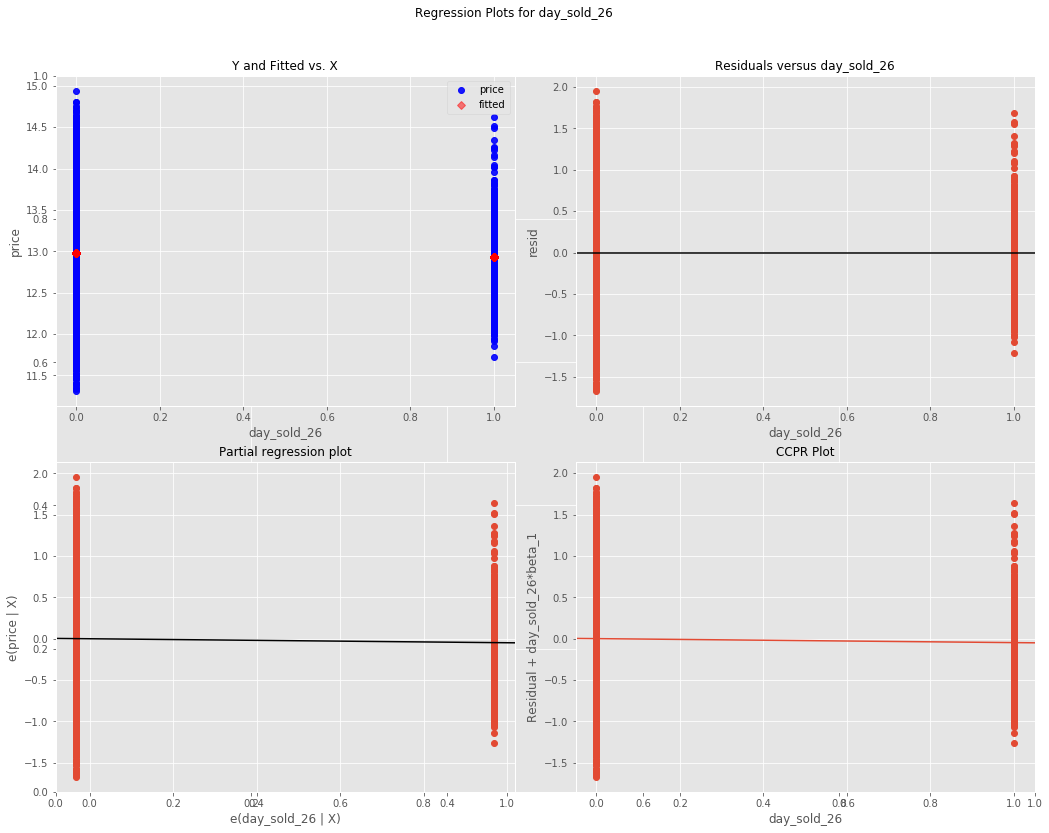

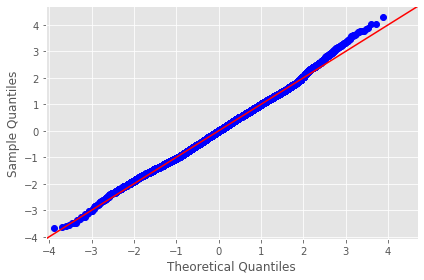

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_31
-------------------------------------------------------------------------------------


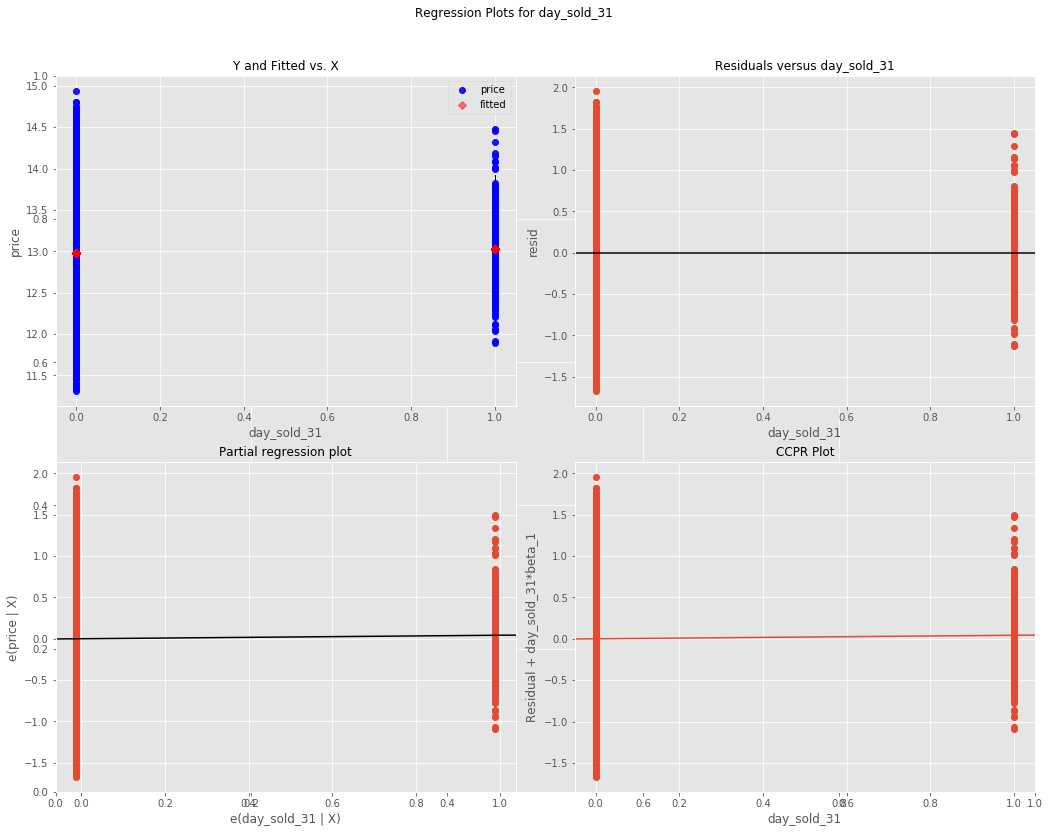

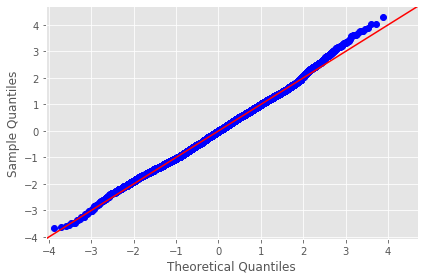

In [117]:
# evaluate residuals to check assumptions
dataset = pd.concat([y, X], axis=1)
results = []
for idx, column in enumerate(dataset.columns):
    print (f"KC Housing DataSet - Regression Analysis and Diagnostics for log_price~{column}")
    print ("-------------------------------------------------------------------------------------")

    f = f'price~{column}'
    model = smf.ols(formula=f, data=dataset).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [118]:
pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])

ind_var  r_squared     intercept     slope        p-value  \
0               price   1.000000  3.552714e-14  1.000000   0.000000e+00   
1   log_sqft_living15   0.267369  7.002123e+00  0.797194   0.000000e+00   
2               grade   0.339789  1.064975e+01  0.312206   0.000000e+00   
3       sqft_basement   0.078416  1.289900e+01  0.000312   0.000000e+00   
4           floors_15   0.007090  1.297111e+01  0.132447   1.148663e-31   
5         condition_5   0.007894  1.297126e+01  0.147549   4.470459e-35   
6        waterfront_1   0.013879  1.297980e+01  0.827031   1.619888e-60   
7     log_sqft_living   0.330989  7.679264e+00  0.706871   0.000000e+00   
8            bedrooms   0.077435  1.245213e+01  0.160478   0.000000e+00   
9           floors_30   0.001732  1.298001e+01  0.112636   7.471907e-09   
10        condition_4   0.000083  1.298580e+01 -0.009298   2.062329e-01   
11             view_2   0.020595  1.297012e+01  0.336145   3.417660e-89   
12             view_4   0.026530  1.297613e+01  0.773289  1.112452e-114   
13             view_1   0.009889  1.297786e+01  0.382165   1.514392e-43   
14             view_3   0.018316  1.297484e+01  0.456465   1.915704e-79   
15          year_sold   0.000155 -1.138076e+01  0.012095   8.345347e-02   
16          floors_25   0.005240  1.298081e+01  0.440413   8.165892e-24   
17     year_sold_2015   0.000155  1.297935e+01  0.012095   8.345347e-02   
18        condition_3   0.000716  1.299943e+01 -0.025299   2.034324e-04   
19          floors_20   0.039833  1.291637e+01  0.189714  2.448278e-172   
20        day_sold_26   0.000342  1.298478e+01 -0.048224   1.027966e-02   
21        day_sold_31   0.000102  1.298277e+01  0.042572   1.612790e-01   

    normality (JB)  
0        40.838011  
1        45.591321  
2        71.256746  
3        47.400858  
4        71.974162  
5        52.823250  
6        39.041757  
7        89.641361  
8        41.533312  
9        78.248810  
10       70.432796  
11       72.342074  
12       32.792556  
13       67.674917  
14       52.951830  
15       68.307418  
16       65.036435  
17       68.307418  
18       60.211338  
19      120.343148  
20       70.194356  
21       68.431722

In [119]:
# further preprocess as no variables are meeting linearity requirement
